In [ ]:
import numpy as np
import pagn.constants as ct
import matplotlib.pyplot as plt
import pagn
import argparse

import NT_disk_Eqns_V1 as jscript
import binary_formation_distribution_V8 as myscript
import binary_formation_distribution_V11 as myscript2

from scipy.interpolate import UnivariateSpline

from os import makedirs
import os

import pandas as pd
import matplotlib.patches as patch

import Novikov
import Thompson_edited as edit
from scipy.interpolate import interp1d
from pagn.opacities import electron_scattering_opacity
#some nicer code based on Test_zone.ipynb

In [208]:
MSun=ct.MSun
G=ct.G
c=ct.c
yr=ct.yr
pc=ct.pc

def NT_disc_solver(MBH, spin, alpha, mdot, le, eps, steps, printing=True, plotting=True, save_to_file=True):
    #general scaling from Abramowicz and Fragile
    M=MBH * G /(c*c)
    R_G=M

    m=MBH/MSun
    Rsch= 2*G*MBH/c**2

    if mdot==None and le==None:
        raise ValueError('Please provide an accretion rate or Eddington ratio!')
    elif le==None:
        le=mdot*eps
    elif mdot==None:
        mdot=le/eps

    Rout=1e7*R_G
    sigma = (200 * 1e3) * (MBH / (1.3e8*MSun)) ** (1 / 4.24)
    Mdot_out = 320*(MSun/yr)*(Rout/(95*pc)) * (sigma/(188e3))**2
    
    Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc
    r_isco=jscript.R_isco_function(MBH, spin)

    R=np.logspace(np.log10(r_isco), np.log10(Rout), steps+1)
    # R=np.linspace(r_isco, Rmax, steps+1)

    R_im=jscript.R_inner_mid(r_isco, MBH, mdot, alpha)
    R_mo=jscript.R_mid_outer(r_isco, mdot)
    R_oa=jscript.R_outer_AGN(r_isco, MBH, mdot, alpha)

    Rs=[]
    sigmas=[]
    Hs=[]
    hrs=[]
    rho0s=[]
    rhos=[]
    Ts=[]

    flag=0
    flag3=0

    r_rel=0

    inner_flag=0
    inner_transition_flag=0
    mid_flag=0
    mid_transition_flag=0
    outer_flag=0

    sf_i=0

    k=50

    for i in range(k, steps+1):
        r=R[i]
        y=np.sqrt(r/M)
        rstar=(r/M)

        #######TO EDIT

        if rstar<0.5*R_im:
            if inner_flag==0:
                if printing==True:
                    print(f'disk confidently in inner region')
                inner_flag=1
            rho_0=jscript.rho_0_NT(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_2(r, MBH, spin, mdot)
            sigma=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)

        if 0.5*R_im<=rstar<5*R_im:
            if inner_transition_flag==0:
                if printing==True:
                    print(f'disk in inner-mid transition region')
                inner_transition_flag=1
            
            param_in=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)
            param_mid=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)

            if param_in-param_mid>0:
                if mid_flag==0:
                    if printing==True:
                        print(f'disk transitions to middle region at {rstar} Rg')
                        r_im=rstar
                    mid_flag=1
                rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
                T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
                H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
                sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)
            else:
                sigma=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)
                rho_0=jscript.rho_0_NT(r, MBH, spin, mdot, alpha)
                T=jscript.T_NT(r, MBH, spin, mdot, alpha)
                H=jscript.H_NT_2(r, MBH, spin, mdot)
            
        
        if 5*R_im<=rstar<0.5*R_mo:
            rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
            sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)

        if 0.5*R_mo<=rstar<100*R_mo:
            if mid_transition_flag==0:
                if printing==True:
                    print(f'disk in mid-outer transition region')
                mid_transition_flag=1
            
            param_out=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)
            param_mid=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)

            if param_mid-param_out>0:
                if outer_flag==0:
                    if printing==True:
                        print(f'disk transitions to outer region at {rstar} Rg')
                        r_mo=rstar
                    outer_flag=1
                rho_0=jscript.rho_0_NT_Outer(r, MBH, spin, mdot, alpha)
                T=jscript.T_NT_Outer(r, MBH, spin, mdot, alpha)
                H=jscript.H_NT_Outer(r, MBH, spin, mdot, alpha)
                sigma=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)
            else:
                rho_0=jscript.rho_0_NT_Middle(r, MBH, spin, mdot, alpha)
                T=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)
                H=jscript.H_NT_Middle(r, MBH, spin, mdot, alpha)
                sigma=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)
        
        if 5*R_mo<rstar:
            rho_0=jscript.rho_0_NT_Outer(r, MBH, spin, mdot, alpha)
            T=jscript.T_NT_Outer(r, MBH, spin, mdot, alpha)
            H=jscript.H_NT_Outer(r, MBH, spin, mdot, alpha)
            sigma=jscript.Sigma_NT_Outer(r, MBH, spin, mdot, alpha)

        ########END
        
        sigmas.append(sigma)
        Ts.append(T*jscript.K_to_eV)
        Hs.append(H)
        rho0s.append(rho_0)
        Rs.append(rstar)

        hr=H/(100*r)

        hrs.append(hr)

        rho=sigma/(2*H)
        rhos.append(rho)

        omega=np.sqrt(G * MBH / (r*r*r))

        v=omega * r
        vc=v/c

        Qt= omega*omega / (2 * np.pi * G * rho)

        if vc<0.1 and flag==0:
            if printing==True:
                print(f'disk stops being relativistic at {r/R_G} Rg')
            r_rel=r
            flag+=1
    return(sigmas, Ts, Hs, rho0s, Rs, hrs)
        

0.01
### Novikov-Thorne 1973 parameters ###
Mbh = 1.000000e+05 MSun
spin =  0.9
mdot =  0.01
eps = 0.1
le = 0.1
Rg = 4.785061e-09 pc
Rmin = 2.320883e+00 Rg
Rmax = 2.000000e+07 Rg, 9.570121e-02 pc
alpha = 0.1
b = 0
X = 0.7
disk in inner-mid transition region
disk transitions to middle region at 5.157296404416091 Rg
disk in mid-outer transition region
disk stops being relativistic at 100.55465168508995 Rg
disk transitions to outer region at 910.9282193586073 Rg
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.01
Rs = 9.570121e-09 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-02 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8692 (R=1.54e+06 Rs)
Beginning star formation at index 8692
Mdisk = 3093.761102781169 Msun
Mdisk/Mbh = 0.030937611027811694
disk confidently in inner region
disk in inner-mid transition region
disk transitions to middle region at 2.800629894

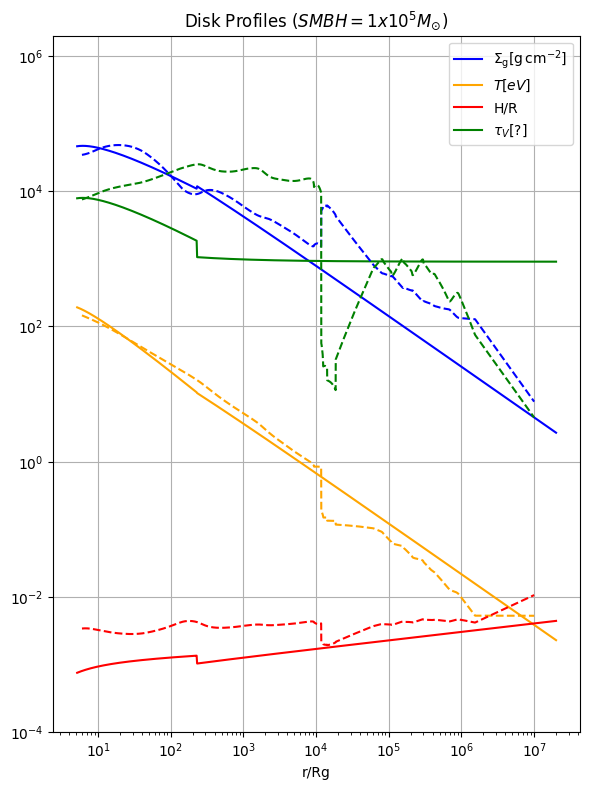

In [213]:
mass_sec=np.genfromtxt("BHs_single_Zsun_rapid_nospin.dat",usecols=(0),skip_header=3,unpack=True)

winds=True

MBH_power=5

MBH_digit=1

Mbh=MBH_digit * 10**MBH_power * ct.MSun

Mmean=10 * ct.MSun 

alpha=0.1
eps=0.1
spin=0.9
le=0.01

Ledd=jscript.Ledd(Mbh, X=0.7)
Mdot_edd = Ledd / (eps*ct.c ** 2)
Mdot = le * Mdot_edd

mdot=Mdot/Mdot_edd

print(mdot)

TT='G23'
DT='NT'

if DT=="SG":
    disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

if DT=="NT":
    disk = Novikov.NovikovThorneAGN(Mbh=Mbh, alpha=alpha, mdot=mdot, eps=eps, spin=spin)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

disk2 = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
Rmin = disk2.Rmin
Rmax = disk2.Rmax
disk2.solve_disk()

sigma, T, H, rho0, R, hr = NT_disc_solver(MBH=Mbh, alpha=alpha, mdot=mdot, eps=eps, spin=spin, steps=int(1e4), le=None)


R_G=Mbh * ct.G /(ct.c*ct.c)

Rsch = 2 * ct.G * Mbh / ct.c**2
Rs = disk.R / Rsch

colour='plasma'
cmap = plt.colormaps[colour]

plt.figure(figsize=(6, 8))
plt.plot(disk.R/(R_G), 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$', color='b')
plt.plot(disk.R/(R_G), disk.T*jscript.K_to_eV, label = r"$T [eV] $", color='orange')
plt.plot(disk.R/(R_G), disk.h/disk.R, label = r"H/R", color='r')
plt.plot(disk.R/(R_G), disk.tauV, label = r'$\tau_V [?]$', color='g')
plt.xlabel("r/Rg")

plt.plot(disk2.R/(2*R_G), 2*disk2.h*disk2.rho*ct.SI_to_gcm2, color='b', linestyle='--')
plt.plot(disk2.R/(2*R_G), disk2.T*jscript.K_to_eV,  color='orange', linestyle='--')
plt.plot(disk2.R/(2*R_G), disk2.h/disk2.R,  color='r', linestyle='--')
plt.plot(disk2.R/(2*R_G), disk2.tauV,  color='g', linestyle='--')


plt.ylim(1e-4, 2e6)
plt.xscale('log')
plt.yscale('log')
# plt.axvline(x=disk.R_AGN/(2*R_G), linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'Disk Profiles ($SMBH = {MBH_digit}x10^{MBH_power}$'r'${M_{\odot}})$')
plt.legend()

plt.grid()
plt.tight_layout()
# plt.savefig(f'Torques/{DT}/Wind/disc_profiles_MBH{MBH_digit}e{MBH_power}_alpha{alpha}.pdf')
plt.show()

In [214]:
def mdot_damped(m, disk, gamma, r):
    ##from Zhen Pan, Huan Yang (2021), eq. 36
    ##initially developed by Kocsis, Yunes, Loeb (2011)
    ##combining equations 3-7 from Chen, Ren, Dai (2023)

    ledd=jscript.Ledd(m, 0.7)

    Mbh=disk.Mbh
    Mdot=disk.Mdot

    alpha=disk.alpha

    m_edd=ledd/(ct.c**2)

    h_ratio = disk.h / disk.R
    sigma = 2*disk.h*disk.rho
    delta_v_phi = (3. - gamma) / 2. * h_ratio * disk.cs #eq.39a
    # delta_v_phi=disk.Omega*disk.R - np.sqrt(Mbh/) to code
    delta_v_dr = 1.5 * (m / (3. * Mbh))**(1./ 3.) * h_ratio**(-1.) * disk.cs #eq. 39c

    # print(f'gamma:{gamma}, h_ratio:{h_ratio}, cs:{disk.cs}')

    R_G=Mbh * ct.G /(ct.c*ct.c)

    vgas=-disk.Mdot/(2 * np.pi * disk.R * sigma)
    vstar=-1.3e-6 * (m/(10*ct.MSun))/(Mbh/(1e5*ct.MSun)) * (disk.R/10*R_G)**(-3)

    delta_v_r=np.abs(vgas-vstar)

    vrel2 = (delta_v_phi + delta_v_dr)**2 + delta_v_r**2 

    R_Hill = disk.R * (m / (3. * disk.Mbh))**(1./3.)
    R_BHL = ct.G * m / (vrel2 + disk.cs**2) #Bondi radius

    #eqn 6 from Chen Ren Dai
    r_rel=np.minimum(R_BHL, R_Hill)
    Rd_gap= 0.21 * (m/Mbh)**(1/2) * (disk.h/disk.R)**(-3/4) * alpha**(-1/4) * disk.R

    # print(f'rrel: {r_rel}, delta_v_phi:{delta_v_phi}, delta_v_dr:{delta_v_dr}, delta_v_r:{delta_v_r}')

    rho=[]

    for i in range(0, len(r_rel)):
        if r_rel[i]>Rd_gap[i]:
            rho.append(disk.rho[i])
        elif r_rel[i]<Rd_gap[i]:
            # print(1/(1+ (0.04 * (m/Mbh)**2 * (disk.h[i]/disk.R[i])**(-5) * alpha**(-1))))
            rho_d_gap= disk.rho[i] * 1/(1+ (0.04 * (m/Mbh)**2 * (disk.h[i]/disk.R[i])**(-5) * alpha**(-1)))
            rho.append(rho_d_gap)

    rho=np.array(rho)

    # print(f'rho: {rho}, m: {m}, vrel2: {vrel2}, cs: {disk.cs}')

    mdot_BHL =  (ct.G)**2 * 4.0 * np.pi * rho * m**2. / (vrel2 + disk.cs**2.)**1.5  #Bondi accretion rate, eq.37

    mdot_inflow=mdot_BHL * np.minimum(1., np.minimum(disk.h/R_BHL, R_Hill/R_BHL))

    #eqn 7 from Chen Ren Dai
    r_obd=(vrel2**(1/2) * r_rel)**2 /(ct.G * m) 
    vk=(ct.G * m /r_obd)**(1/2)
    Qco = 2 * alpha * (disk.h/r_obd)**3 * vk**3 /(ct.G * mdot_inflow)

    mdot_obd=[]

    for i in range(0, len(Qco)):
        if Qco[i]>=1:
            mdot_obd.append(mdot_inflow[i])
        elif Qco[i]<1:
            mdot_damp=2 * alpha * (disk.h[i]/r_obd[i])**3 * vk[i]**3 /(ct.G)
            mdot_obd.append(mdot_damp)

    mdot_obd=np.array(mdot_obd)
    Mdot_flux = Mdot * np.abs(1-vstar/vgas)

    # for i in range(0, len(mdot_BHL)):
        # print(1, disk.h[i]/R_BHL[i], R_Hill[i]/R_BHL[i],  Mdot_flux[i]/mdot_BHL[i])
        # if Mdot_flux[i]<mdot_BHL[i]:
        #     print(f'Quenched by limited gas supply at {disk.R[i]/R_G} Rg')
    mdot_wind = np.minimum(mdot_obd, Mdot_flux)
    return mdot_wind

def mdot_dutycycle(m, disk, gamma):
    #eqn 34 from Chen Ren Dai 2023
    rg=m * ct.G /(ct.c*ct.c)
    mdot_wind = mdot_damped(m, disk, gamma)
    mdot_reduced=mdot_wind /()
    
def gamma_wind(m, disk, gamma):
    ##from Zhen Pan, Huan Yang (2021), eq. 36
    ##initially developed by Kocsis, Yunes, Loeb (2011)
    h_ratio = disk.h / disk.R
    delta_v_phi = (3. - gamma) / 2. * h_ratio * disk.cs #eq.39a

    mdot_wind = mdot_damped(m, disk, gamma, disk.R)

    dot_J = - disk.R * delta_v_phi * mdot_wind
    return dot_J

def file_opener(filename):
    with open(filename) as f:
        lines = f.readlines()
    header_end = 0
    data = pd.read_csv(filename, delimiter=" ", skiprows=header_end)
    data.columns = [col.strip().replace(",", "") for col in data.columns]
    return data

def compute_torque(disk, M, Mbh, TT):
    q = M / Mbh

    ## Kanagawa+2018 prescription
    K= q**2 / disk.alpha  / (disk.h/disk.R)**5
    Sigma_reduced = 1./(1.+0.04*K) * (2. * disk.rho * disk.h)
    # NB the position of traps is now m dependent!!
    # is it true that you only pair up at low K??
    ##
    
    #Gamma_0 = gamma_0(q, disk.h / disk.R, 2 * disk.rho * disk.h, disk.R, disk.Omega)
    Gamma_0 = myscript2.gamma_0(q, disk.h / disk.R, Sigma_reduced, disk.R, disk.Omega)

    dSig =  myscript2.dSigmadR_reduced(disk, Sigma_reduced)
    dT =  myscript2.dTdR(disk)
    cI_p10 =  myscript2.CI_p10(disk, dSig, dT)
    Gamma_I_p10 = cI_p10*Gamma_0
    cI_jm17 =  myscript2.CI_jm17(dSig, dT, 5/3, disk)
    cL =  myscript2.CL(dSig, dT, 5/3, disk)
    Gamma_I_jm17 = (cL + cI_jm17)*Gamma_0

    if TT=="B16": 
        return Gamma_I_p10 ##+ Gamma_GW
    elif TT=="G23": 
        gamma = 5/3
        Gamma_therm = myscript2.gamma_thermal(gamma, disk, q)*Gamma_0
        return Gamma_therm + Gamma_I_jm17 
    

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 1.298344e-06 MSun/yr
le = 0.005
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9297 (R=3.66e+06 Rs)
Beginning star formation at index 9297
Mdisk = 245.76616136699414 Msun
Mdisk/Mbh = 0.024576616136699415
Mass: 1.000e+04, alpha:0.005, le:0.005, wind: 0.9999989270358914, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+04 MSun
Mdot = 2.596689e-06 MSun/yr
le = 0.01
Rs = 9.570121e-10 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-03 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=9288 (R=3.61e+06 Rs)
Beginning star formation at index 9288
Mdisk = 322.8988699728189 Msun
Mdisk/Mbh = 0.032289886997281886
Mass: 1.000e+04, alpha:0.005, le:0.01, wind: 1.000002243907496, weak

### Sirko & Go

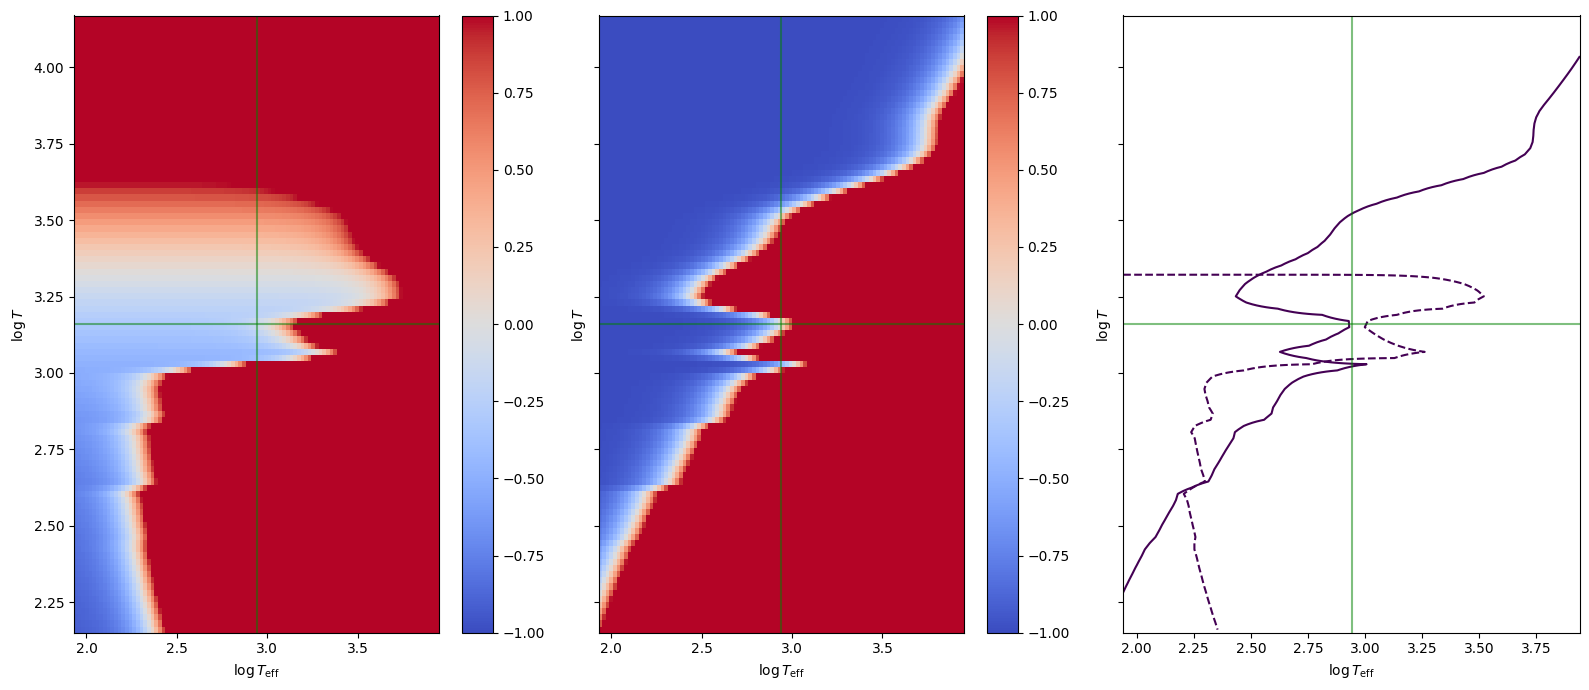

Mdisk = 41799.417742453385 Msun
Mdisk/Mbh = 0.20899708871226694
2e5 0.005 0.05 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+05 MSun
Mdot = 5.193378e-04 MSun/yr
le = 0.1
Rs = 1.914024e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e-01 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6367 (R=5.49e+04 Rs)
Beginning star formation at index 6367
Mdisk = 58782.26625564375 Msun
Mdisk/Mbh = 0.2939113312782188
Mass: 2.000e+05, alpha:0.005, le:0.1, wind: 1.2292562414031065, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+05 MSun
Mdot = 1.298344e-03 MSun/yr
le = 0.25
Rs = 1.914024e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e-01 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6653 (R=8.28e+04 Rs)
Beginning star formation at index 6653
Mdisk = 79565.45502853887 Msun
Mdisk/Mbh = 0.397827

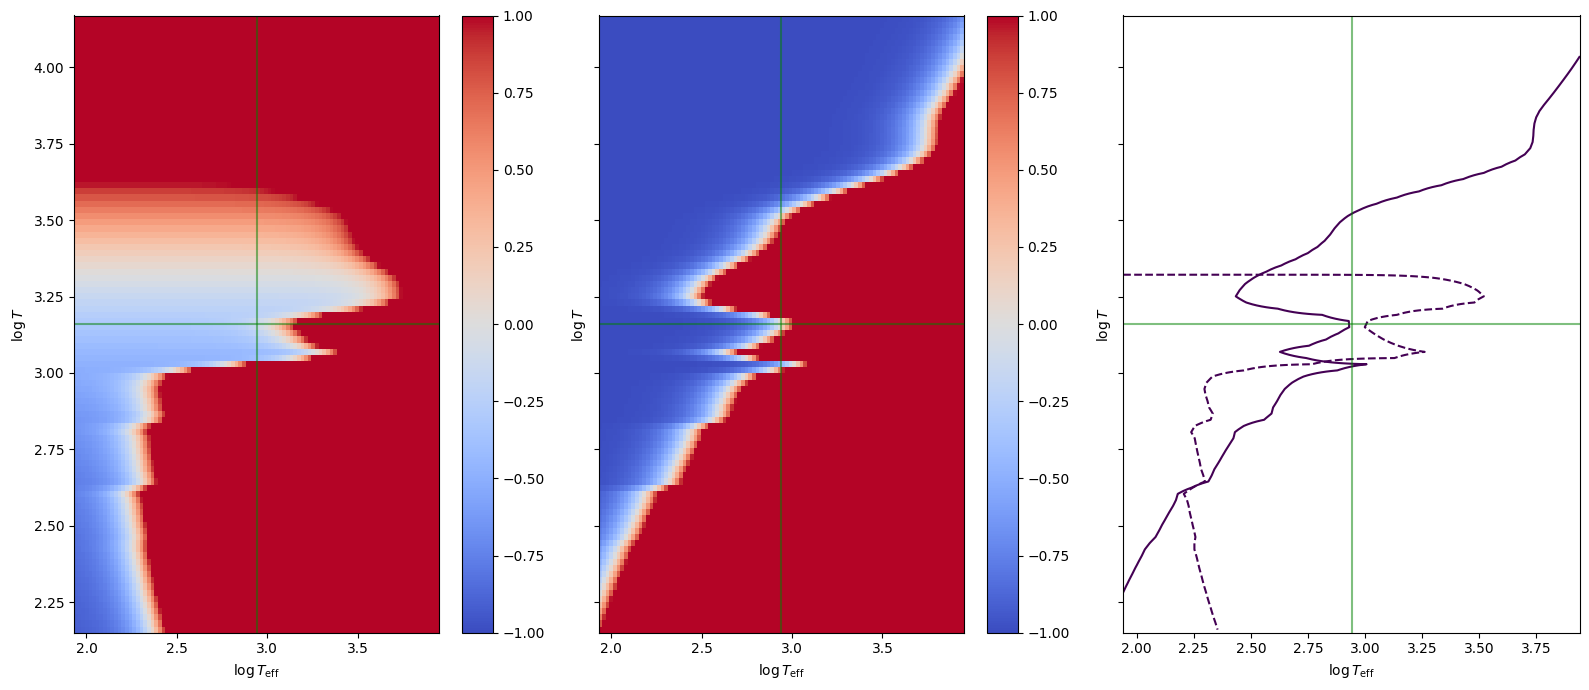

Mdisk = 41567.13150351471 Msun
Mdisk/Mbh = 0.20783565751757357
2e5 0.01 0.1 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+05 MSun
Mdot = 1.298344e-03 MSun/yr
le = 0.25
Rs = 1.914024e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6543 (R=7.07e+04 Rs)
Beginning star formation at index 6543
Mdisk = 62919.496401821896 Msun
Mdisk/Mbh = 0.3145974820091095
Mass: 2.000e+05, alpha:0.01, le:0.25, wind: 1.321633094611827, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+05 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.5
Rs = 1.914024e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6757 (R=9.61e+04 Rs)
Beginning star formation at index 6757
Mdisk = 79194.9181825519 Msun
Mdisk/Mbh = 0.395974590912

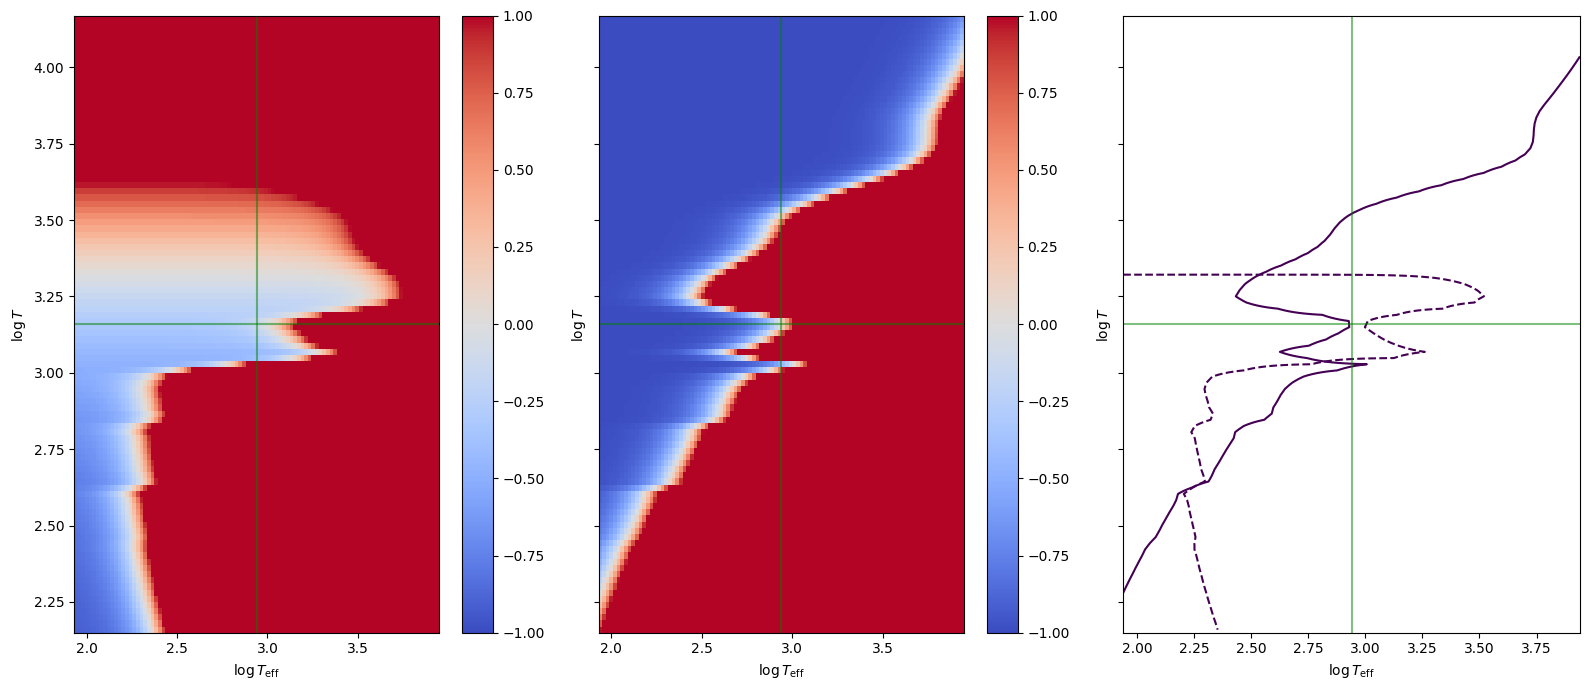

Mdisk = 40727.130624049976 Msun
Mdisk/Mbh = 0.2036356531202499
2e5 0.1 1 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+05 MSun
Mdot = 2.596689e-05 MSun/yr
le = 0.005
Rs = 1.914024e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e-01 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8695 (R=1.54e+06 Rs)
Beginning star formation at index 8695
Mdisk = 3587.016127118368 Msun
Mdisk/Mbh = 0.01793508063559184
Mass: 2.000e+05, alpha:0.5, le:0.005, wind: 1.0001752645528044, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+05 MSun
Mdot = 5.193378e-05 MSun/yr
le = 0.01
Rs = 1.914024e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e-01 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=8642 (R=1.43e+06 Rs)
Beginning star formation at index 8642
Mdisk = 4571.134303308467 Msun
Mdisk/Mbh = 0.0228556715165

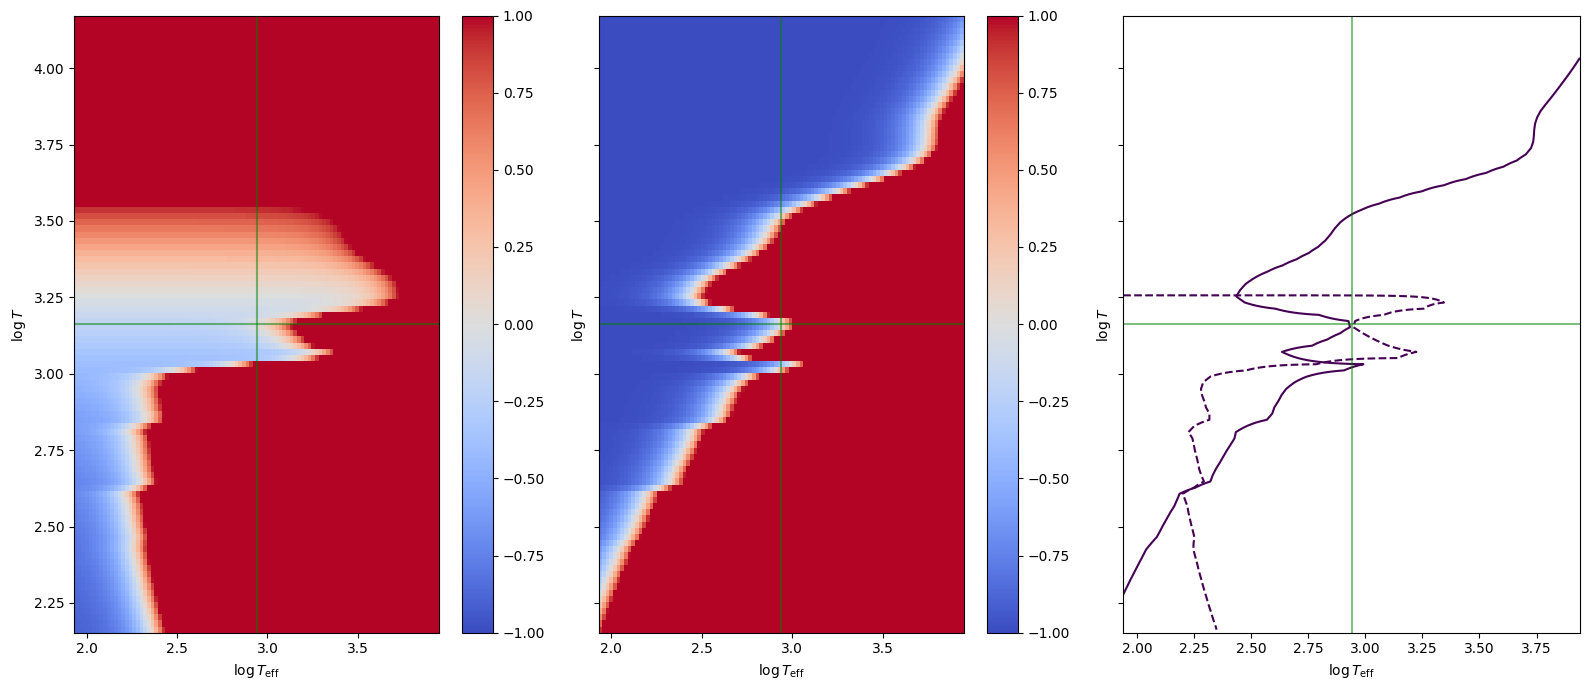

Mdisk = 96200.3985543711 Msun
Mdisk/Mbh = 0.12025049819296389
8e5 0.005 0.01 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+05 MSun
Mdot = 5.193378e-04 MSun/yr
le = 0.025
Rs = 7.656097e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e-01 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5720 (R=2.17e+04 Rs)
Beginning star formation at index 5720
Mdisk = 240994.18978738989 Msun
Mdisk/Mbh = 0.3012427372342374
Mass: 8.000e+05, alpha:0.005, le:0.025, wind: 1.550975468716859, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+05 MSun
Mdot = 1.038676e-03 MSun/yr
le = 0.05
Rs = 7.656097e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e-01 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5938 (R=2.97e+04 Rs)
Beginning star formation at index 5938
Mdisk = 303073.2806925001 Msun
Mdisk/Mbh = 0.3788

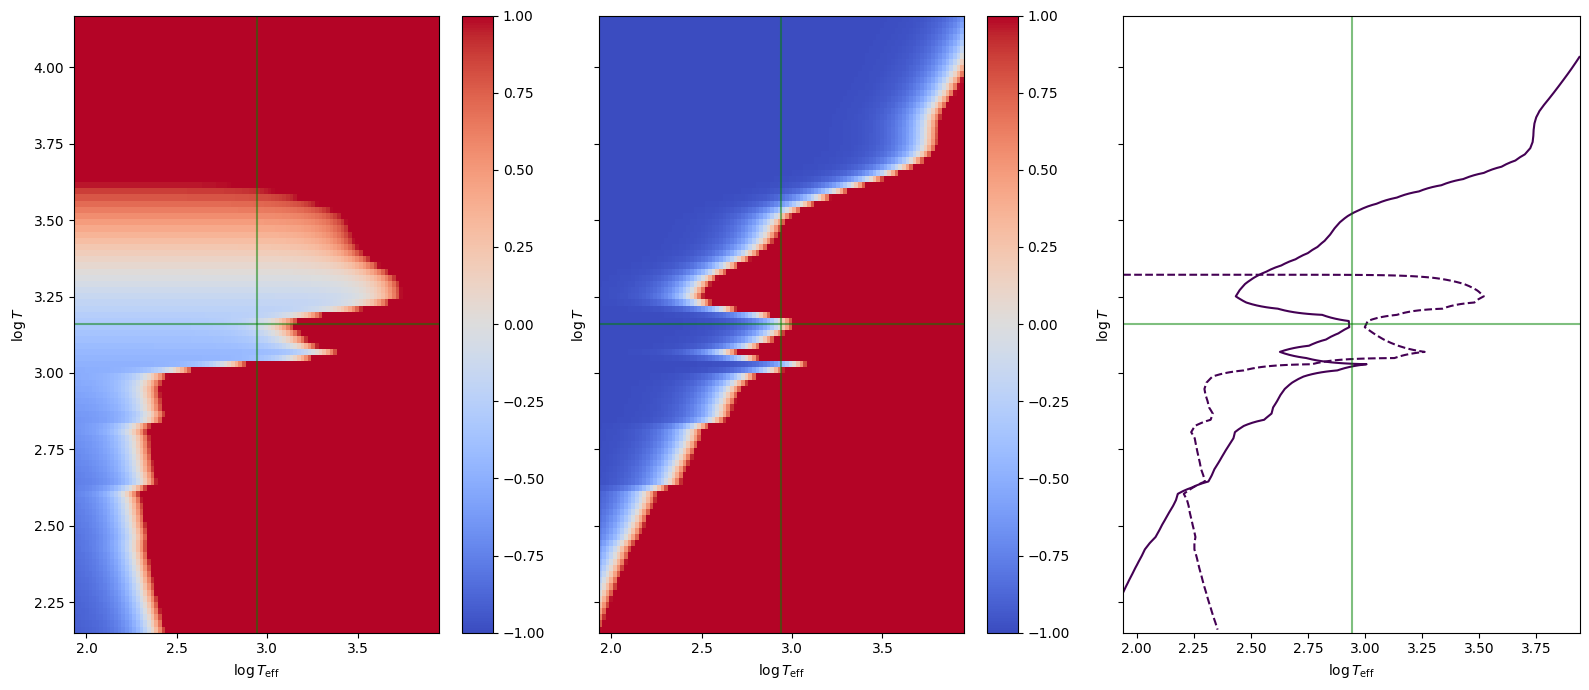

Mdisk = 104724.33690430703 Msun
Mdisk/Mbh = 0.13090542113038378
8e5 0.01 0.025 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+05 MSun
Mdot = 1.038676e-03 MSun/yr
le = 0.05
Rs = 7.656097e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5829 (R=2.54e+04 Rs)
Beginning star formation at index 5829
Mdisk = 240255.30319391895 Msun
Mdisk/Mbh = 0.3003191289923987
Mass: 8.000e+05, alpha:0.01, le:0.05, wind: 1.6059956515192242, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+05 MSun
Mdot = 2.077351e-03 MSun/yr
le = 0.1
Rs = 7.656097e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6042 (R=3.45e+04 Rs)
Beginning star formation at index 6042
Mdisk = 302181.6094853683 Msun
Mdisk/Mbh = 0.3777270

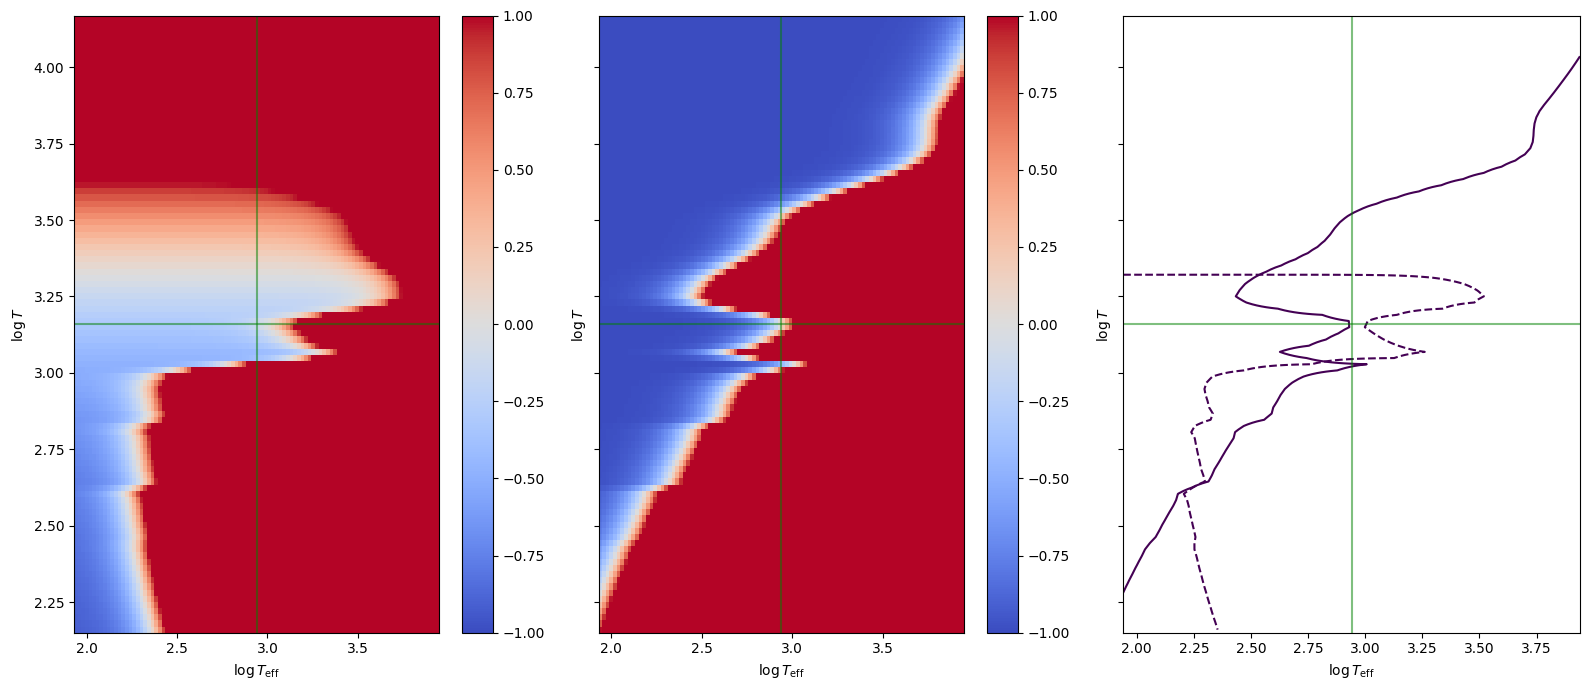

Mdisk = 102526.94784871585 Msun
Mdisk/Mbh = 0.12815868481089482
8e5 0.1 0.25 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+05 MSun
Mdot = 1.038676e-02 MSun/yr
le = 0.5
Rs = 7.656097e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6213 (R=4.41e+04 Rs)
Beginning star formation at index 6213
Mdisk = 237123.90019719242 Msun
Mdisk/Mbh = 0.2964048752464905
Mass: 8.000e+05, alpha:0.1, le:0.5, wind: 3.5290040822949, significant

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+05 MSun
Mdot = 2.077351e-02 MSun/yr
le = 1
Rs = 7.656097e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e-01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6440 (R=6.10e+04 Rs)
Beginning star formation at index 6440
Mdisk = 298188.28447385237 Msun
Mdisk/Mbh = 0.37273535559

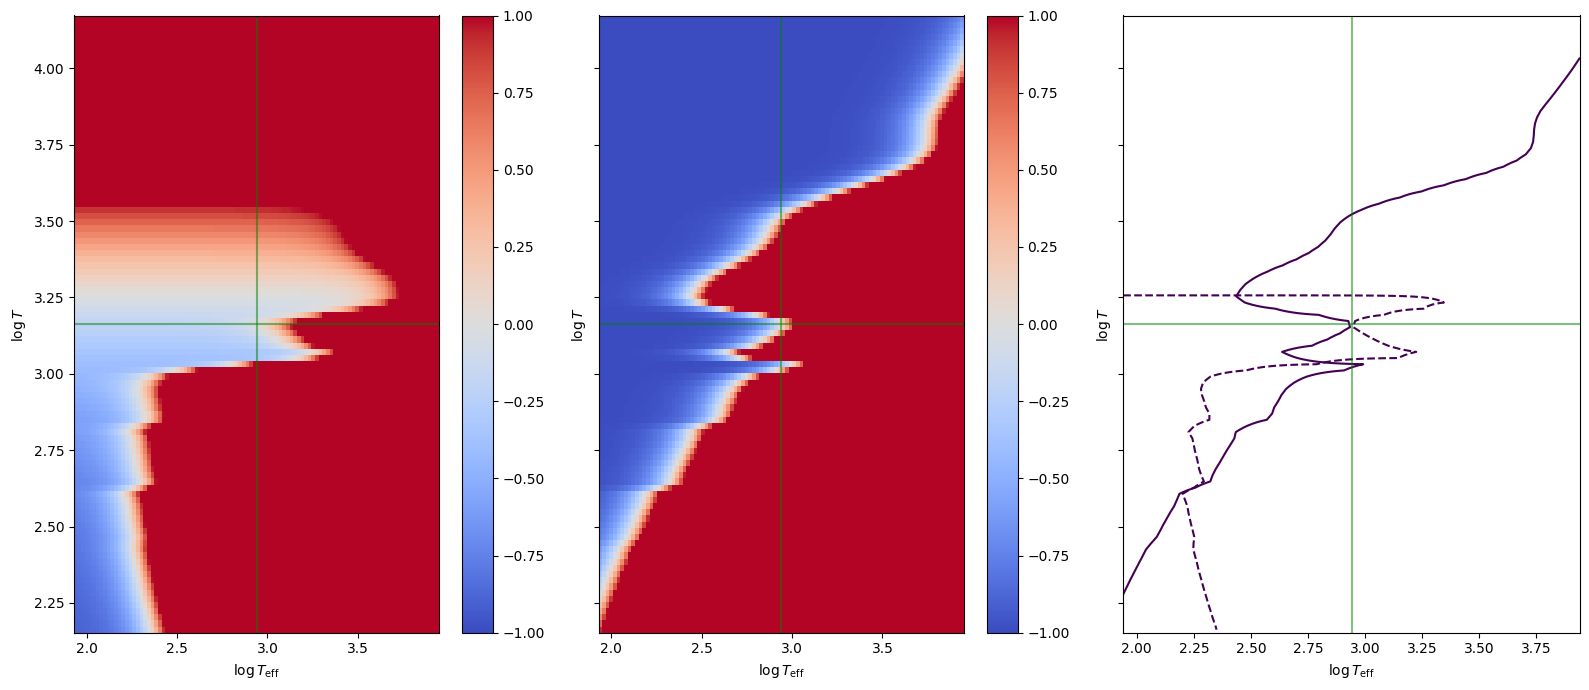

Mdisk = 91437.51425738685 Msun
Mdisk/Mbh = 0.11429689282173358
8e5 0.5 1 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 1.298344e-04 MSun/yr
le = 0.005
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5863 (R=2.67e+04 Rs)
Beginning star formation at index 5863
Mdisk = 191535.1074580841 Msun
Mdisk/Mbh = 0.1915351074580841
Mass: 1.000e+06, alpha:0.005, le:0.005, wind: 1.3193167475875813, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.01
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5409 (R=1.39e+04 Rs)
Beginning star formation at index 5409
No star formation regime solution found at index 9100

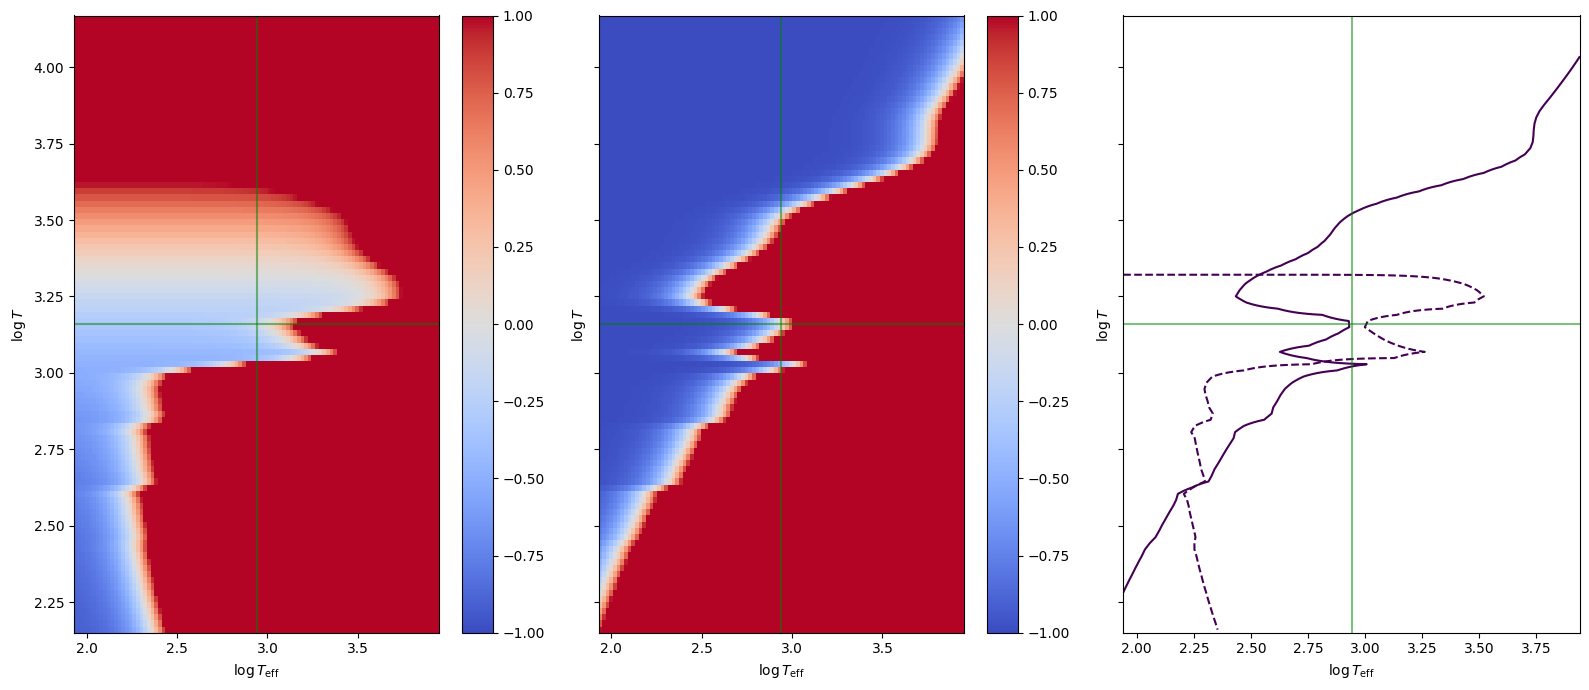

Mdisk = 122269.6067644585 Msun
Mdisk/Mbh = 0.1222696067644585
1e6 0.005 0.01 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 6.491722e-04 MSun/yr
le = 0.025
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5687 (R=2.07e+04 Rs)
Beginning star formation at index 5687
Mdisk = 325196.2780244625 Msun
Mdisk/Mbh = 0.32519627802446255
Mass: 1.000e+06, alpha:0.005, le:0.025, wind: 1.6579513326112716, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 1.298344e-03 MSun/yr
le = 0.05
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5903 (R=2.83e+04 Rs)
Beginning star formation at index 5903
Mdisk = 409417.5102573594 Msun
Mdisk/Mbh = 0.409

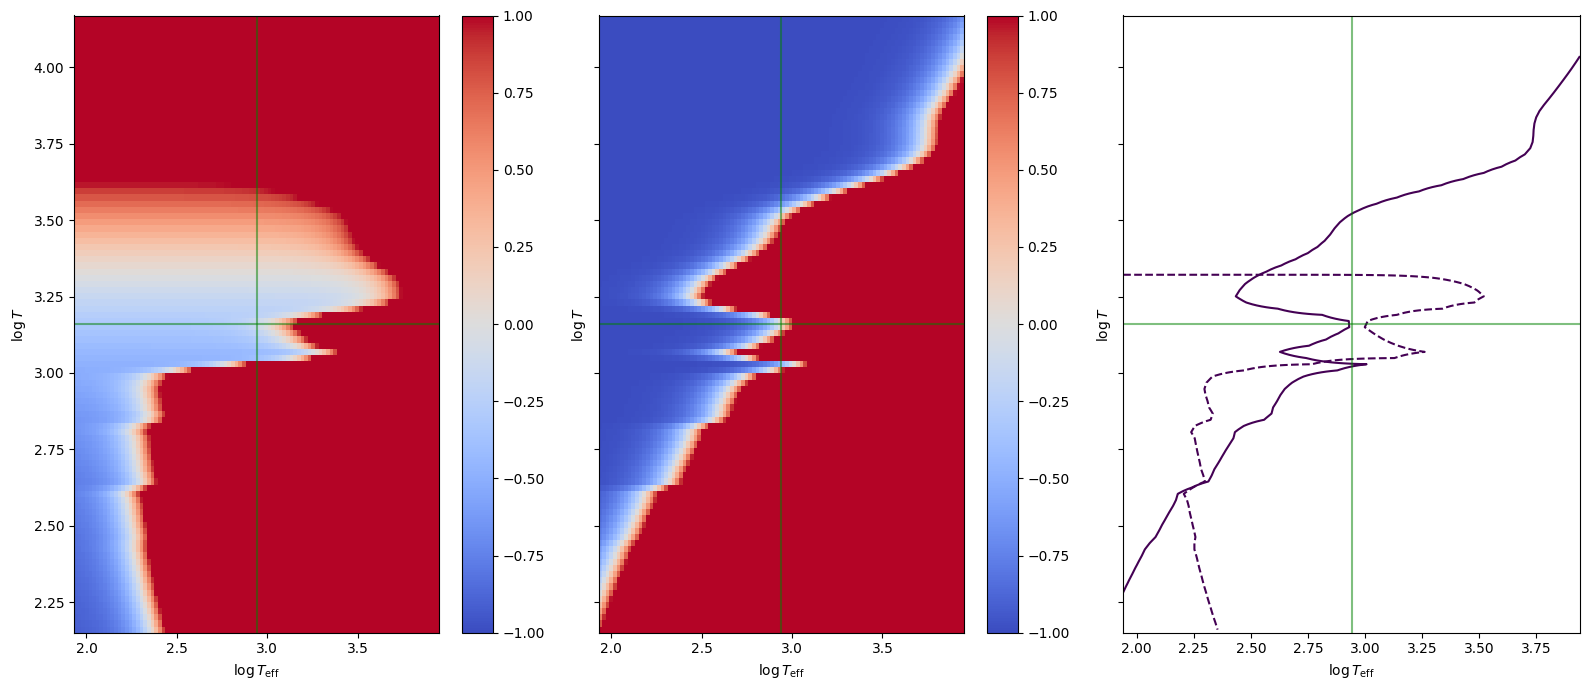

Mdisk = 116088.14904263045 Msun
Mdisk/Mbh = 0.11608814904263046
1e6 0.5 1 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+06 MSun
Mdot = 2.596689e-04 MSun/yr
le = 0.005
Rs = 1.914024e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+00 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5086 (R=8.77e+03 Rs)
Beginning star formation at index 5086
No star formation regime solution found at index 8779 
Zero residuals: [-0.12552609  0.0228552 ]
Last solution: [2.93987478 3.15944568]
Showing root finding solutions for star formation regime
### Plotting yes star formation regime solutions ###
i = 8779 
R = 1.740297e+06 Rs = 3.330971e-01 pc
guess = (log Teff, log T) = (2.9398747787787034 , 3.1594456779005946)
zoom guess = True
###


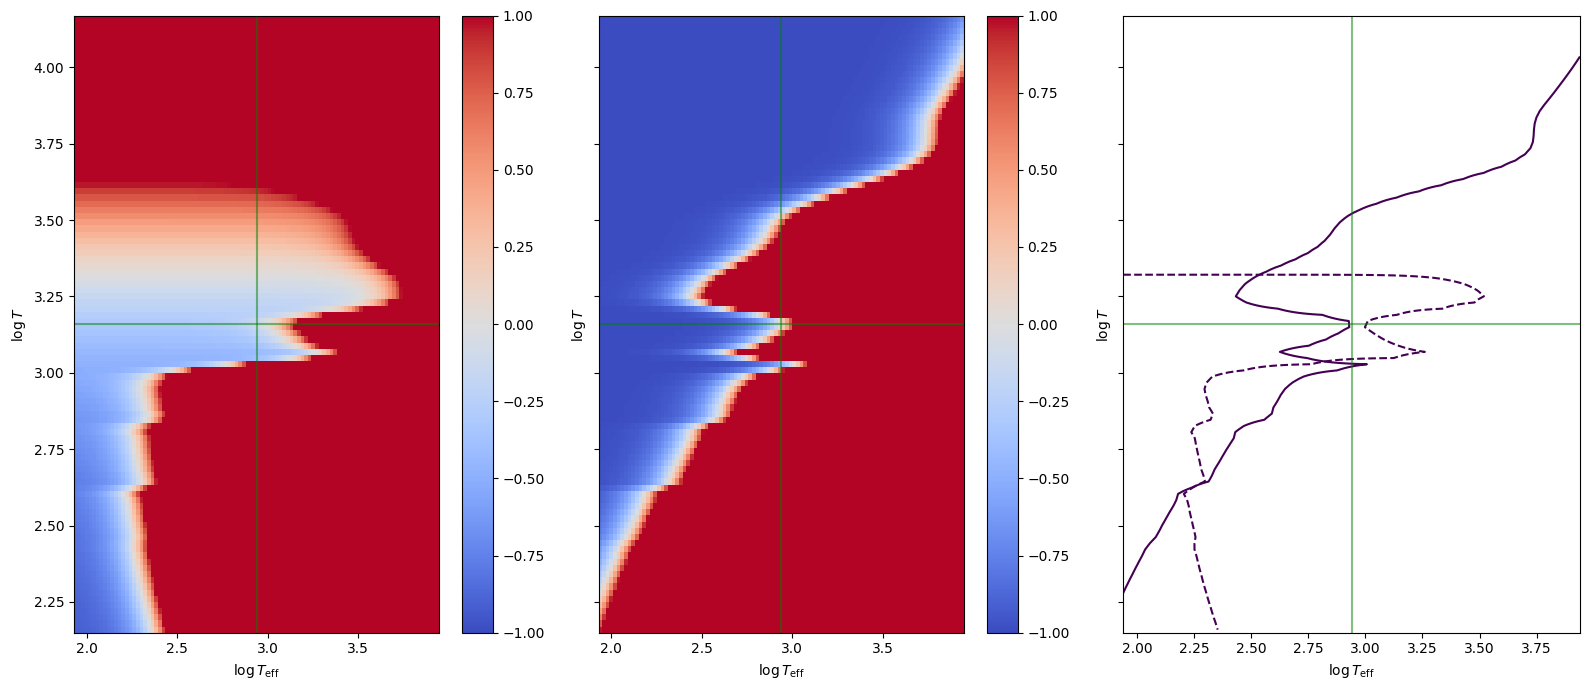

Mdisk = 194275.37934090526 Msun
Mdisk/Mbh = 0.09713768967045262
2e6 0.005 0.005 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+06 MSun
Mdot = 5.193378e-04 MSun/yr
le = 0.01
Rs = 1.914024e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+00 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5293 (R=1.18e+04 Rs)
Beginning star formation at index 5293
Mdisk = 609034.4719173055 Msun
Mdisk/Mbh = 0.3045172359586527
Mass: 2.000e+06, alpha:0.005, le:0.01, wind: 1.799152504474223, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+06 MSun
Mdot = 1.298344e-03 MSun/yr
le = 0.025
Rs = 1.914024e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+00 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5579 (R=1.78e+04 Rs)
Beginning star formation at index 5579
Mdisk = 825563.5744385726 Msun
Mdisk/Mbh = 0.412

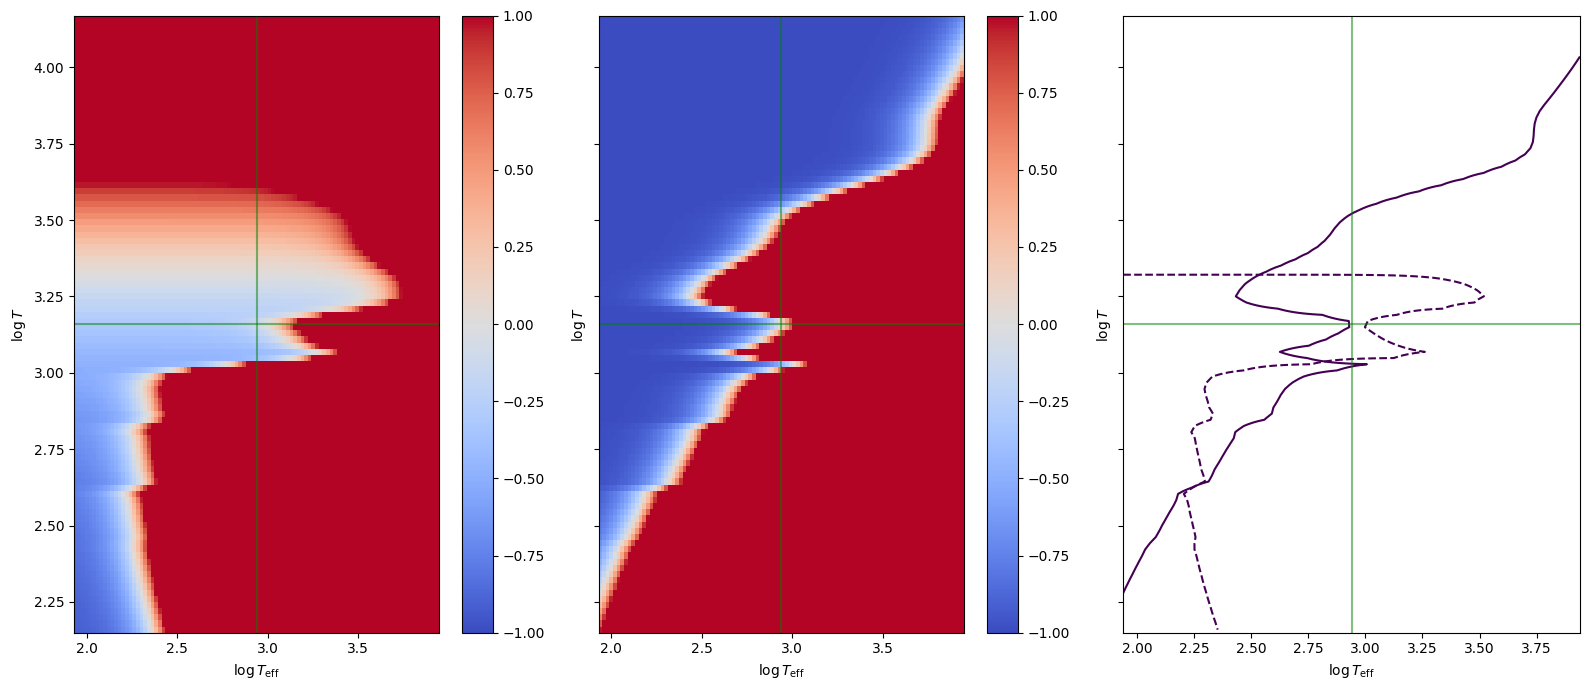

Mdisk = 193202.16282209472 Msun
Mdisk/Mbh = 0.09660108141104735
2e6 0.01 0.01 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+06 MSun
Mdot = 1.298344e-03 MSun/yr
le = 0.025
Rs = 1.914024e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5470 (R=1.52e+04 Rs)
Beginning star formation at index 5470
Mdisk = 654190.9915231398 Msun
Mdisk/Mbh = 0.3270954957615699
Mass: 2.000e+06, alpha:0.01, le:0.025, wind: 1.9092290123943414, weak

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+06 MSun
Mdot = 2.596689e-03 MSun/yr
le = 0.05
Rs = 1.914024e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+00 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5684 (R=2.07e+04 Rs)
Beginning star formation at index 5684
Mdisk = 823844.0227637202 Msun
Mdisk/Mbh = 0.411922

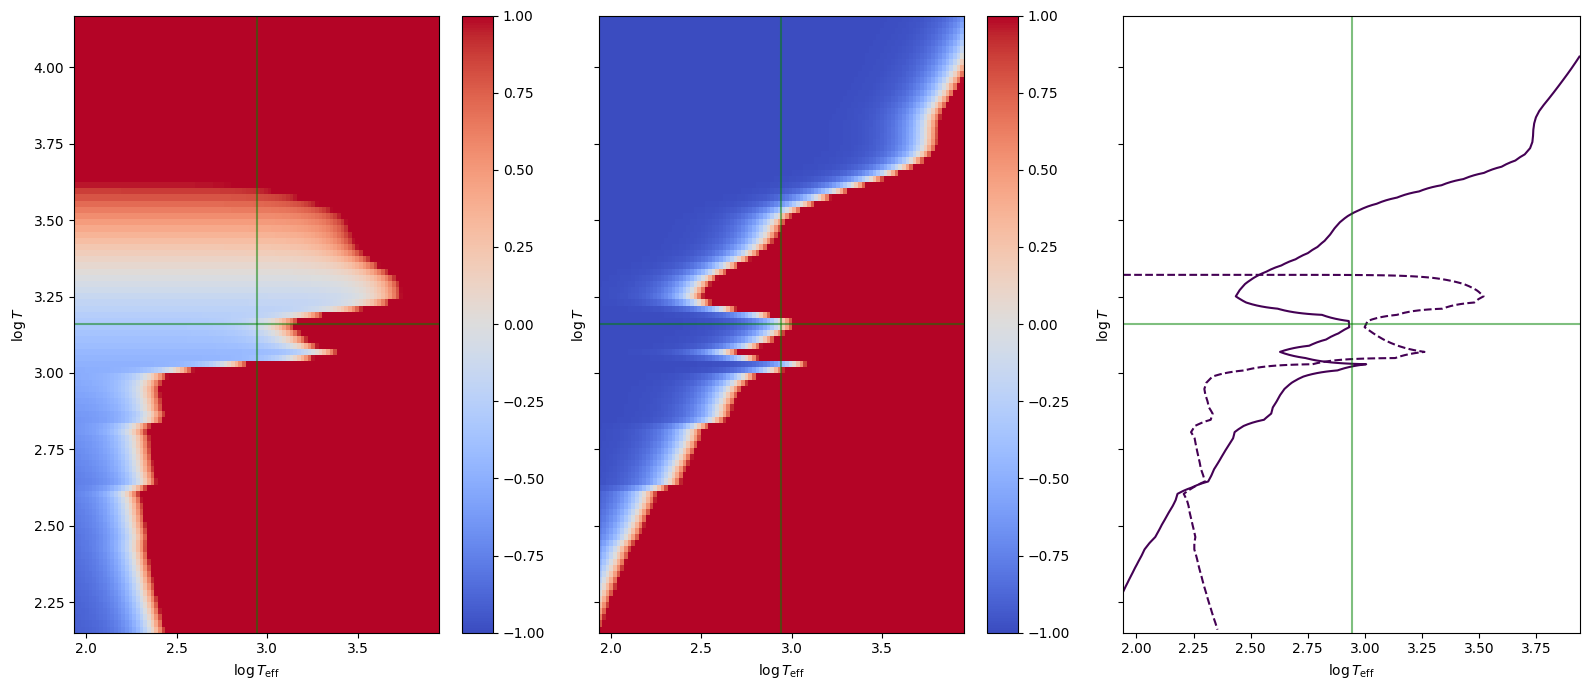

Mdisk = 188281.09580700935 Msun
Mdisk/Mbh = 0.09414054790350468
2e6 0.1 0.1 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+06 MSun
Mdot = 1.298344e-02 MSun/yr
le = 0.25
Rs = 1.914024e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5859 (R=2.65e+04 Rs)
Beginning star formation at index 5859
Mdisk = 647881.1725653535 Msun
Mdisk/Mbh = 0.32394058628267675
Mass: 2.000e+06, alpha:0.1, le:0.25, wind: 4.039186509515301, significant

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+06 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.5
Rs = 1.914024e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6086 (R=3.67e+04 Rs)
Beginning star formation at index 6086
Mdisk = 816149.7710802136 Msun
Mdisk/Mbh = 0.4080748

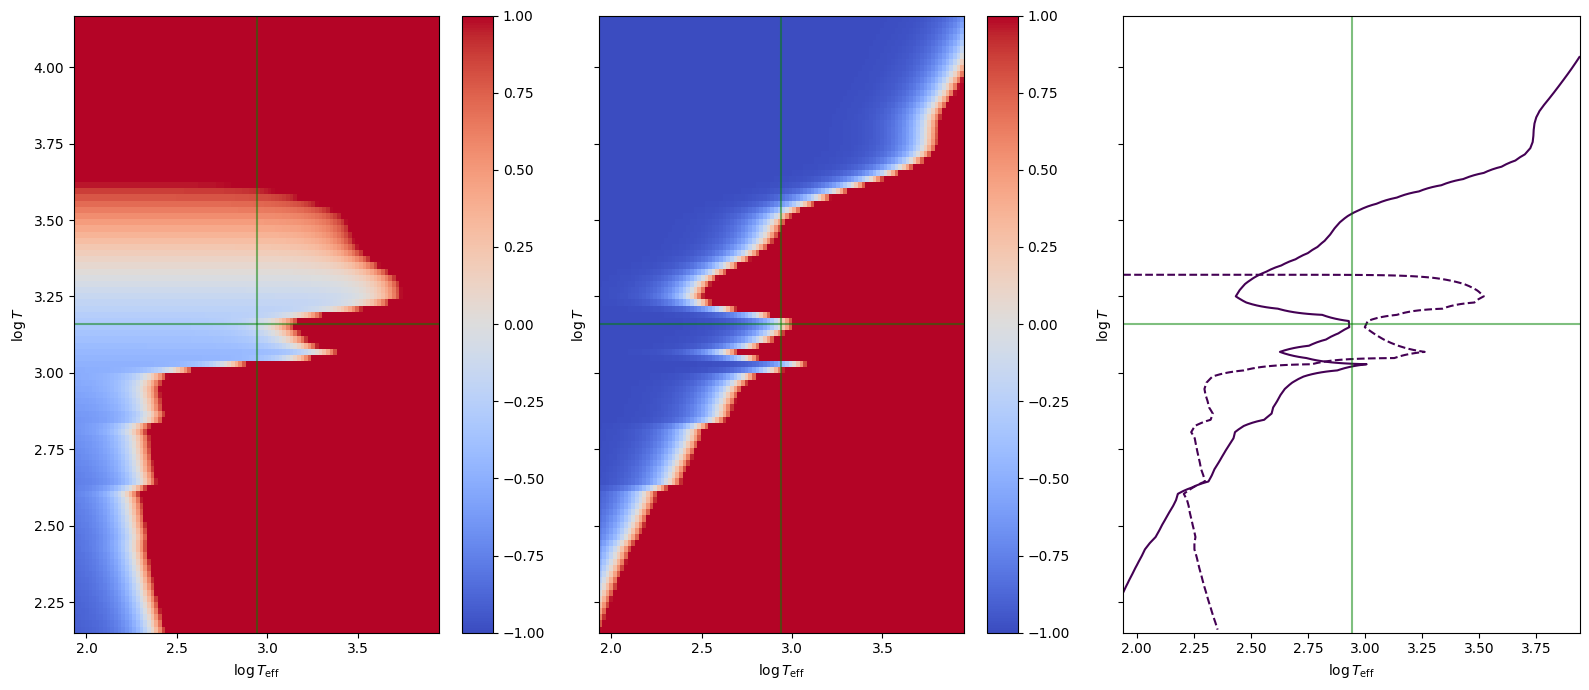

Mdisk = 184325.57438481305 Msun
Mdisk/Mbh = 0.09216278719240653
2e6 0.5 0.5 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+06 MSun
Mdot = 5.193378e-02 MSun/yr
le = 1
Rs = 1.914024e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+00 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=6105 (R=3.77e+04 Rs)
Beginning star formation at index 6105
Mdisk = 595761.1792832396 Msun
Mdisk/Mbh = 0.29788058964161984
Mass: 2.000e+06, alpha:0.5, le:1, wind: 15.29941207940632, strong

### Sirko & Goodman 2003 parameters ###
Mbh = 3.000000e+06 MSun
Mdot = 3.895033e-04 MSun/yr
le = 0.005
Rs = 2.871036e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 2.871036e+00 pc
alpha = 0.005
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5011 (R=7.87e+03 Rs)
Beginning star formation at index 5011
Mdisk = 833933.326961711 Msun
Mdisk/Mbh = 0.277977775653903

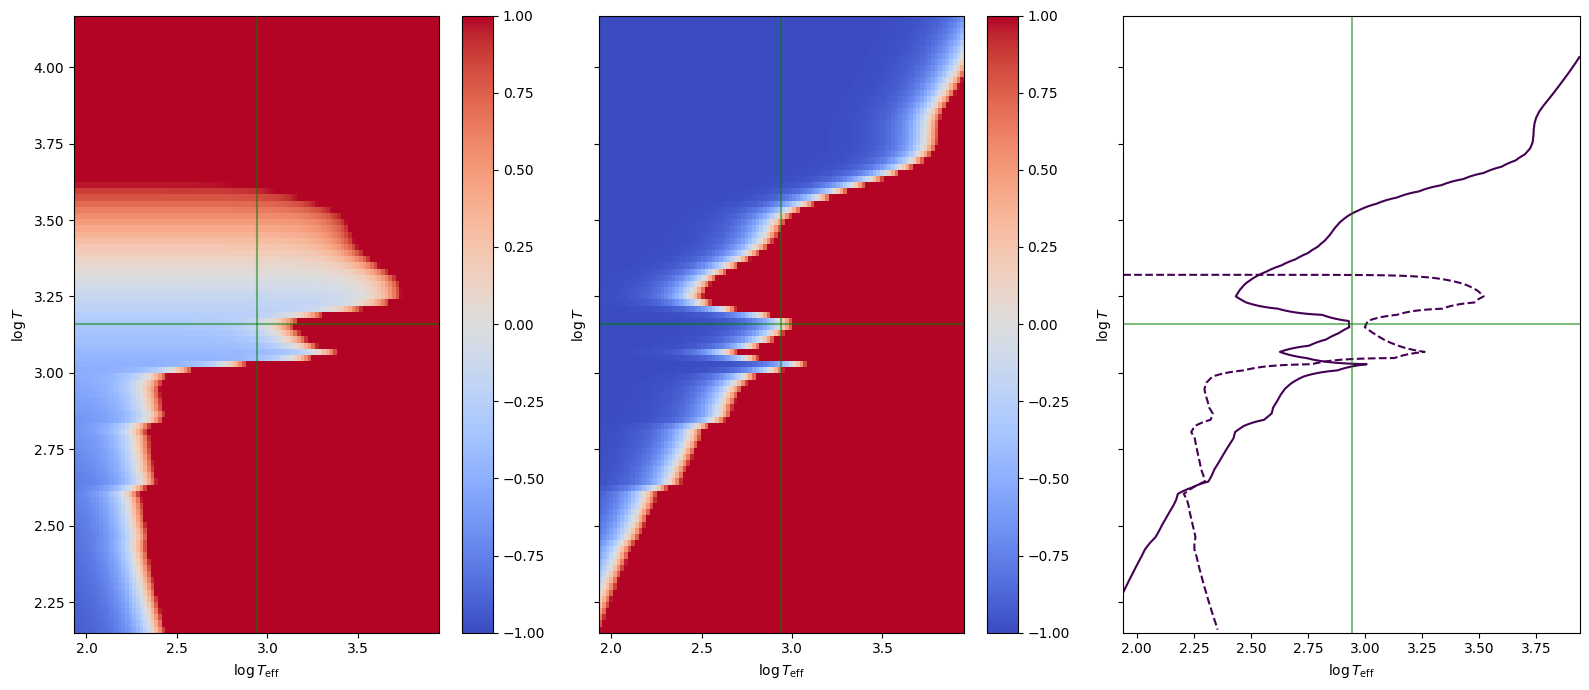

Mdisk = 475331.47849585244 Msun
Mdisk/Mbh = 0.059416434811981556
8e6 0.1 0.025 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+06 MSun
Mdot = 1.038676e-02 MSun/yr
le = 0.05
Rs = 7.656097e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5139 (R=9.46e+03 Rs)
Beginning star formation at index 5139
Mdisk = 2445352.313608885 Msun
Mdisk/Mbh = 0.3056690392011106
Mass: 8.000e+06, alpha:0.1, le:0.05, wind: 4.3713577266206665, strong

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+06 MSun
Mdot = 2.077351e-02 MSun/yr
le = 0.1
Rs = 7.656097e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5366 (R=1.31e+04 Rs)
Beginning star formation at index 5366
Mdisk = 3078244.873393714 Msun
Mdisk/Mbh = 0.384780609

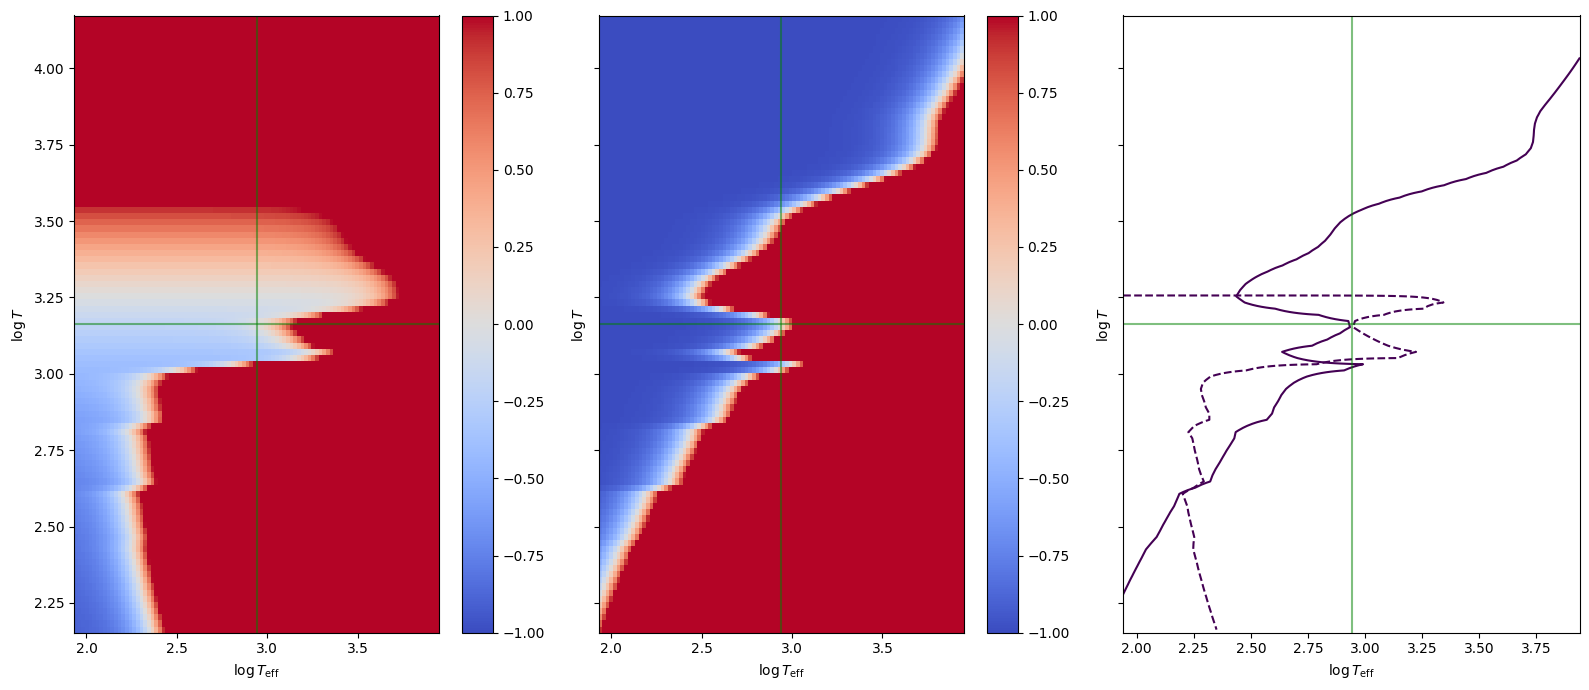

Mdisk = 423959.7120677815 Msun
Mdisk/Mbh = 0.052994964008472686
8e6 0.5 0.1 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+06 MSun
Mdot = 5.193378e-02 MSun/yr
le = 0.25
Rs = 7.656097e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e+00 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5458 (R=1.49e+04 Rs)
Beginning star formation at index 5458
Mdisk = 2429892.1732931174 Msun
Mdisk/Mbh = 0.3037365216616397
Mass: 8.000e+06, alpha:0.5, le:0.25, wind: 11.857276548237156, strong

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+06 MSun
Mdot = 1.038676e-01 MSun/yr
le = 0.5
Rs = 7.656097e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e+00 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5700 (R=2.11e+04 Rs)
Beginning star formation at index 5700
Mdisk = 3058189.2827834776 Msun
Mdisk/Mbh = 0.3822736603

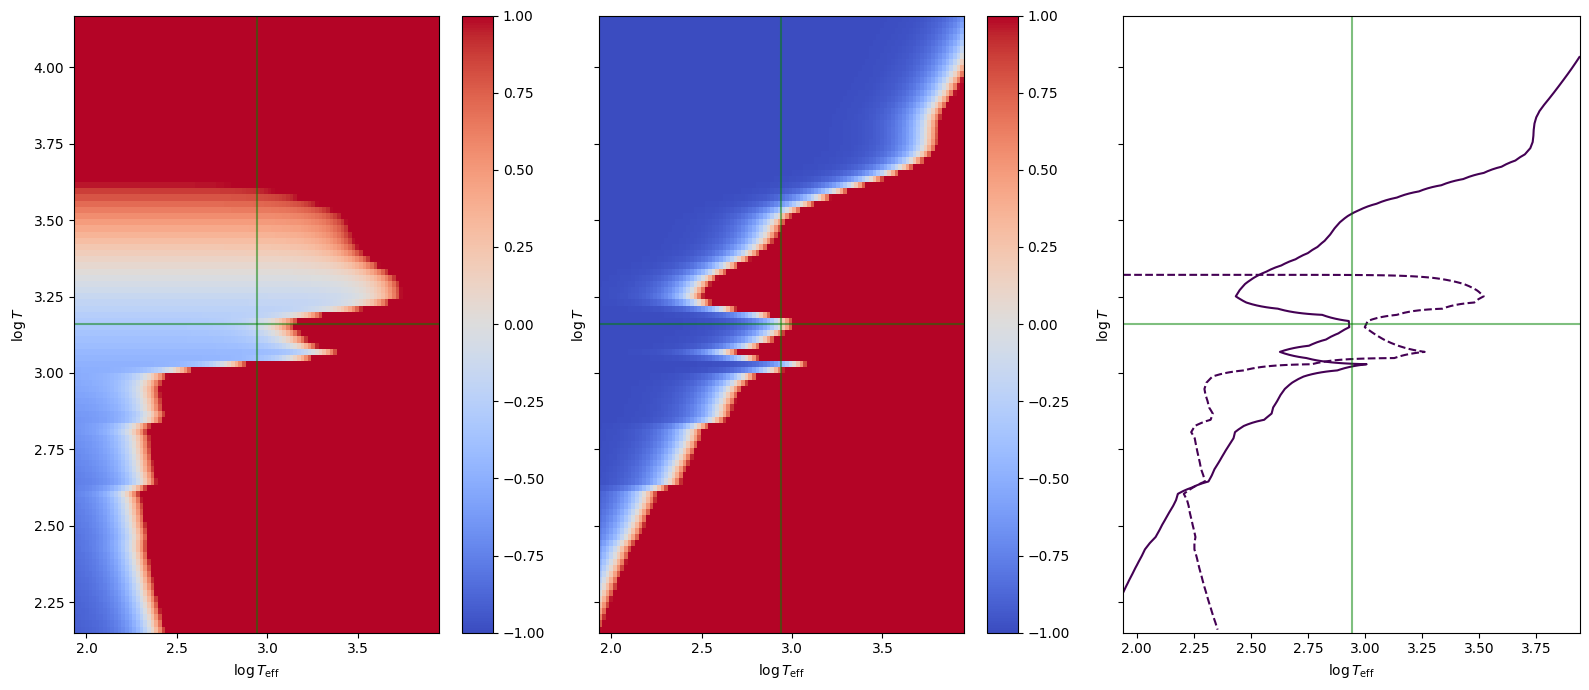

Mdisk = 538615.4383693335 Msun
Mdisk/Mbh = 0.05386154383693335
1e7 0.5 0.1 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 6.491722e-02 MSun/yr
le = 0.25
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5431 (R=1.44e+04 Rs)
Beginning star formation at index 5431
Mdisk = 3277668.201974751 Msun
Mdisk/Mbh = 0.3277668201974751
Mass: 1.000e+07, alpha:0.5, le:0.25, wind: 13.816897505478366, strong

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 1.298344e-01 MSun/yr
le = 0.5
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5676 (R=2.04e+04 Rs)
Beginning star formation at index 5676
Mdisk = 4129421.6147979624 Msun
Mdisk/Mbh = 0.412942161479

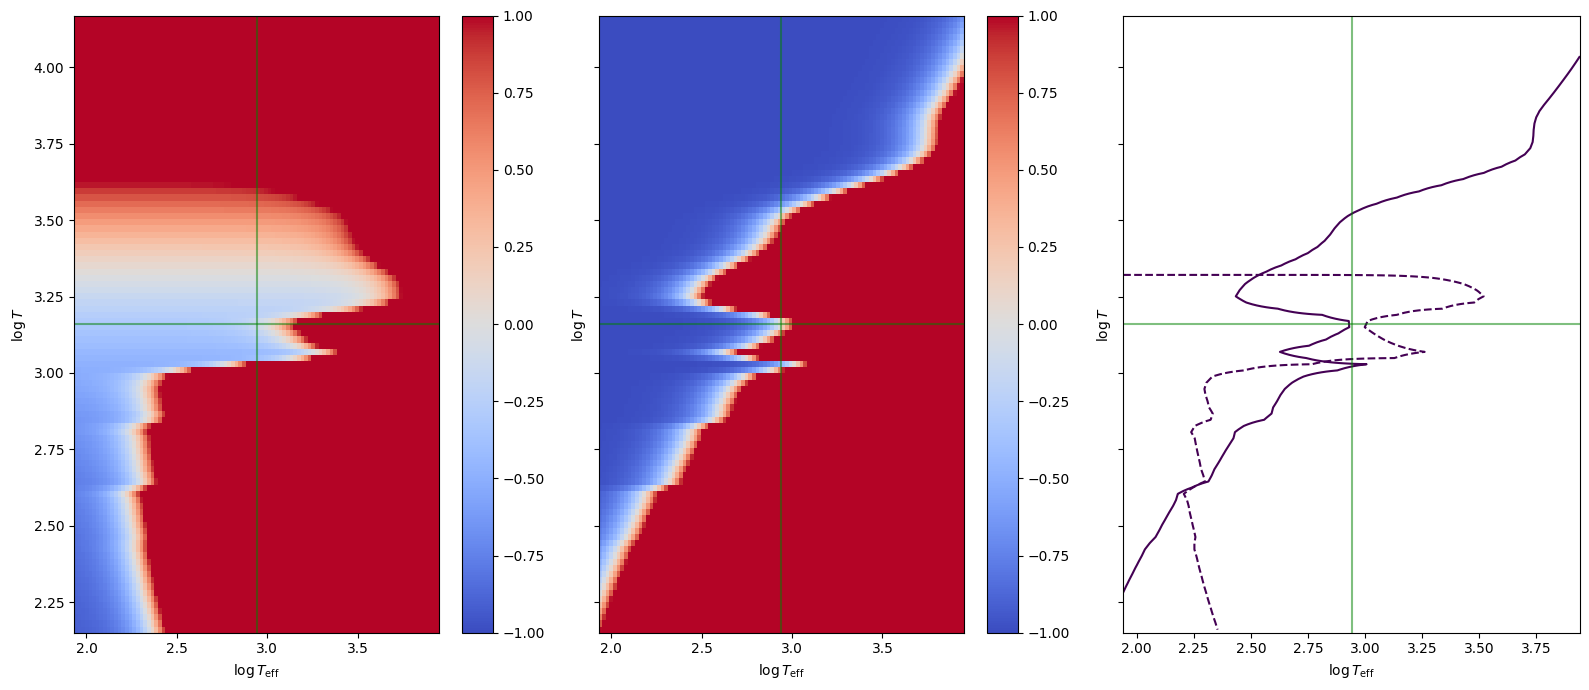

Mdisk = 874708.911287892 Msun
Mdisk/Mbh = 0.0437354455643946
2e7 0.1 0.01 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+07 MSun
Mdot = 1.298344e-02 MSun/yr
le = 0.025
Rs = 1.914024e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4784 (R=5.69e+03 Rs)
Beginning star formation at index 4784
Mdisk = 6628379.658822128 Msun
Mdisk/Mbh = 0.3314189829411064
Mass: 2.000e+07, alpha:0.1, le:0.025, wind: 4.130876467318418, significant

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+07 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.05
Rs = 1.914024e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5011 (R=7.87e+03 Rs)
Beginning star formation at index 5011
Mdisk = 8350391.832510093 Msun
Mdisk/Mbh = 0.4175195

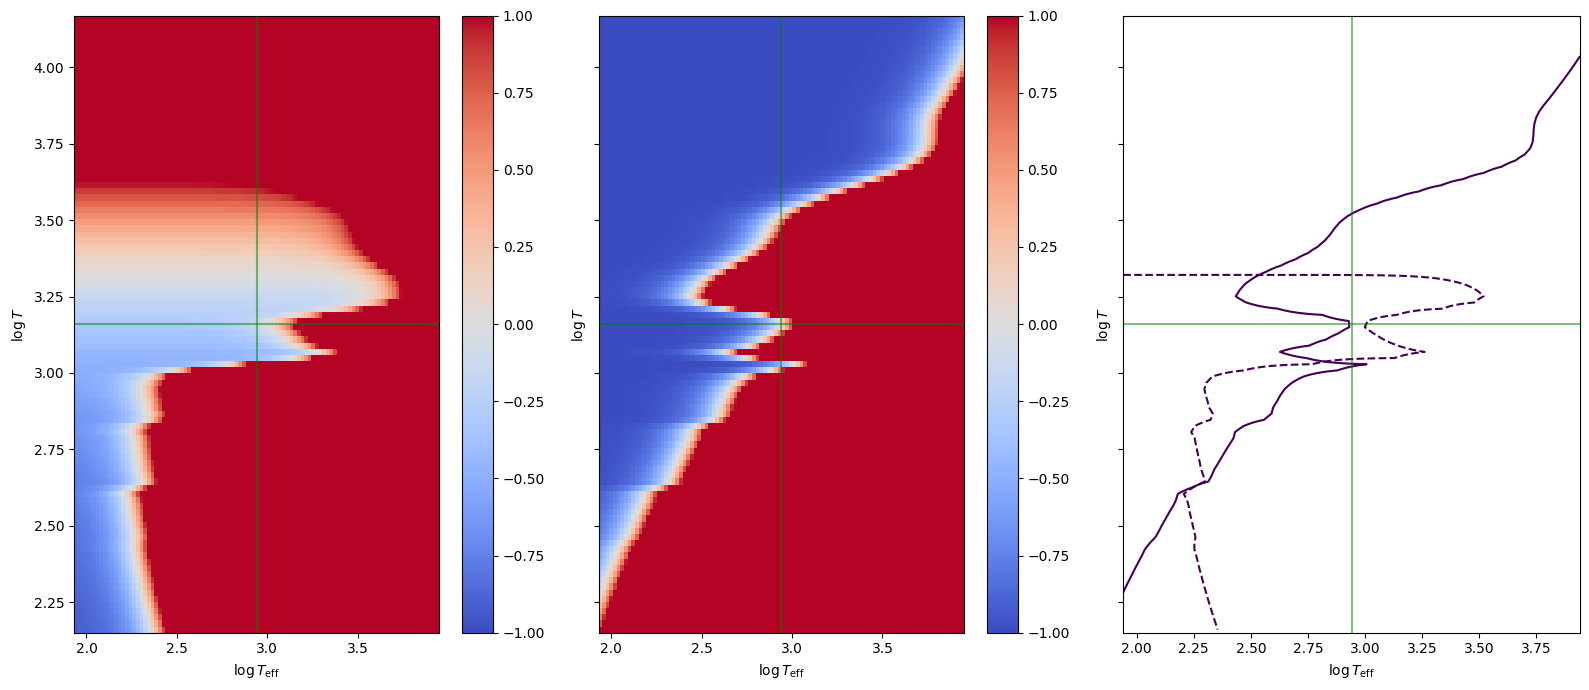

Mdisk = 854370.3346806922 Msun
Mdisk/Mbh = 0.04271851673403461
2e7 0.5 0.05 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+07 MSun
Mdot = 5.193378e-02 MSun/yr
le = 0.1
Rs = 1.914024e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+01 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5030 (R=8.09e+03 Rs)
Beginning star formation at index 5030
Mdisk = 6127085.823392112 Msun
Mdisk/Mbh = 0.3063542911696056
Mass: 2.000e+07, alpha:0.5, le:0.1, wind: 23.785543055641305, strong

### Sirko & Goodman 2003 parameters ###
Mbh = 2.000000e+07 MSun
Mdot = 1.298344e-01 MSun/yr
le = 0.25
Rs = 1.914024e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 1.914024e+01 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5352 (R=1.28e+04 Rs)
Beginning star formation at index 5352
Mdisk = 8311544.814370462 Msun
Mdisk/Mbh = 0.4155772407185

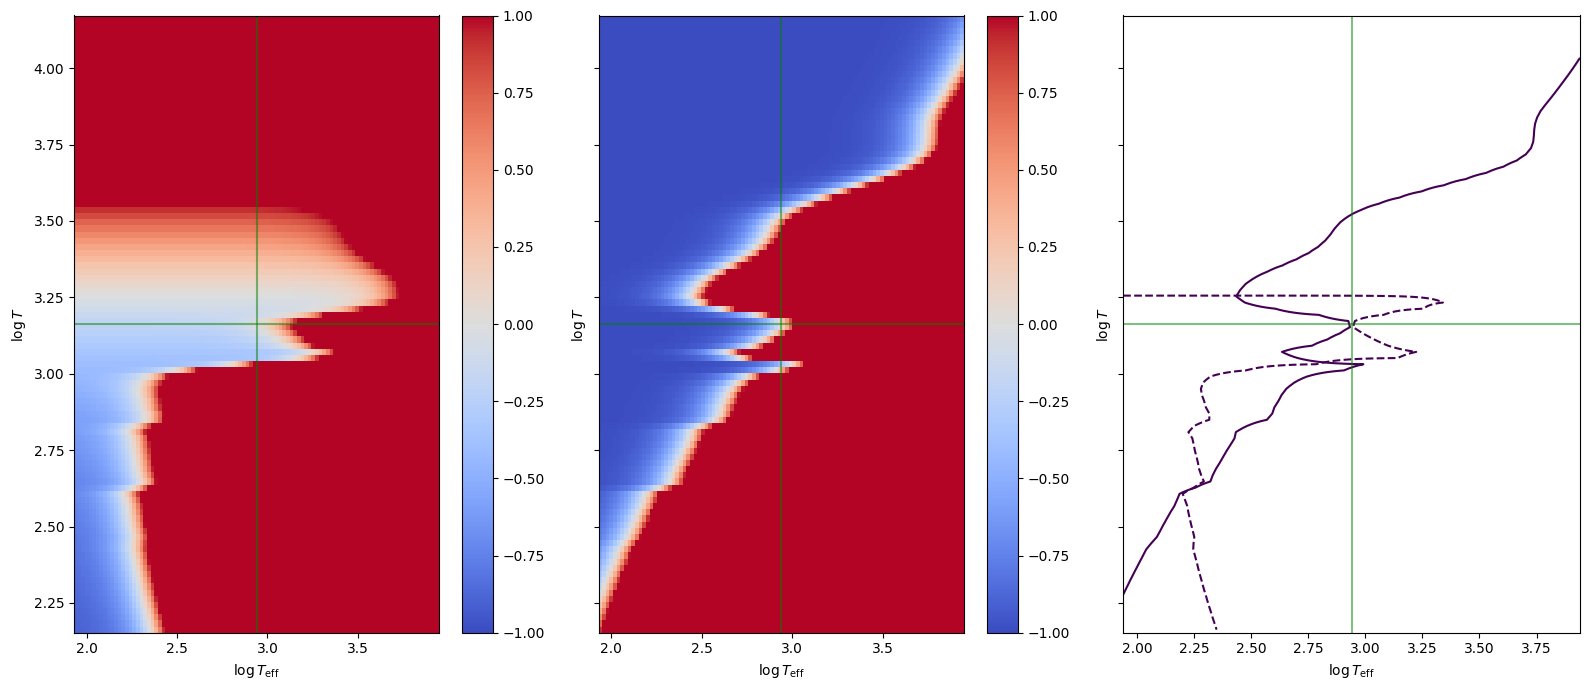

Mdisk = 1967201.973923793 Msun
Mdisk/Mbh = 0.02459002467404741
8e7 0.5 0.01 True ValueError failure

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+07 MSun
Mdot = 5.193378e-02 MSun/yr
le = 0.025
Rs = 7.656097e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e+01 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4381 (R=3.19e+03 Rs)
Beginning star formation at index 4381
Mdisk = 24724722.069175623 Msun
Mdisk/Mbh = 0.30905902586469525
Mass: 8.000e+07, alpha:0.5, le:0.025, wind: 13.628656163577649, strong

### Sirko & Goodman 2003 parameters ###
Mbh = 8.000000e+07 MSun
Mdot = 1.038676e-01 MSun/yr
le = 0.05
Rs = 7.656097e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 7.656097e+01 pc
alpha = 0.5
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4624 (R=4.52e+03 Rs)
Beginning star formation at index 4624
Mdisk = 31135062.548110973 Msun
Mdisk/Mbh = 0.389188

In [268]:
mass_sec=np.genfromtxt("BHs_single_Zsun_rapid_nospin.dat",usecols=(0),skip_header=3,unpack=True)
winds=True
plot=False
save=True

powers = 4,5,6,7
digits = 1, 2, 3, 5, 8,
alphas = 0.005, 0.01, 0.1, 0.5
les = 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1

dir_name = f"Torques/SG/Wind/Mig_Torques/"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
file_name=dir_name+f"/Summary_lower_mbh.txt"
file = open(file_name, "w")
file.write(f"SMBH/Msun, alpha, le, winds, max_wind, with_winds_avg\n")

for MBH_power in powers:
    for MBH_digit in digits:
        for alpha in alphas:
            for le in les:
                Mbh=MBH_digit * 10**MBH_power * ct.MSun
                Mmean=5 * ct.MSun 
                eps=0.1
                spin=0.9

                Ledd=jscript.Ledd(Mbh, X=0.7)
                Mdot_edd = Ledd / (eps*ct.c ** 2)
                Mdot = le * Mdot_edd

                TT='G23'
                DT='SG'

                if DT=="SG":
                    disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
                    Rmin = disk.Rmin
                    Rmax = disk.Rmax
                    disk.solve_disk()
                
                # print(f'mdot:{disk.Mdot/Mdot_edd}')

                # if DT=="NT":
                #     disk = Novikov.NovikovThorneAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps, spin=spin)
                #     Rmin = disk.Rmin
                #     Rmax = disk.Rmax
                #     disk.solve_disk()

                R_G=Mbh * ct.G /(ct.c*ct.c)
                Rsch = 2 * ct.G * Mbh / ct.c**2
                Rs = disk.R / Rsch

                ledd=jscript.Ledd(Mmean, X=0.7)
                Ledd=jscript.Ledd(Mbh, X=0.7)

                Mdot=disk.Mdot #* Ledd / (eps)
                mean_Gamma_GW = jscript.compute_torque_GW(disk, Mmean, Mbh, TT) 

                mean_Gamma_b16 = compute_torque(disk, Mmean, Mbh, 'B16')
                mean_Gamma_jm17 = compute_torque(disk, Mmean, Mbh, 'G23') 

                # for i in range(0, len(disk.rho), 100):
                #     print(f'rho {i}:{disk.rho[i]}')

                drhodr=jscript.drhodR(disk)
                gamma=drhodr
                try:
                    mean_Gamma_wind= gamma_wind(Mmean, disk, gamma)
                except ValueError: 
                    print(f'{MBH_digit}e{MBH_power} {alpha} {le} {winds} ValueError failure\n')
                    continue


                if winds==True:
                    mean_Gamma_tot =  (mean_Gamma_GW+mean_Gamma_jm17+mean_Gamma_wind)
                else:
                    mean_Gamma_tot =  (mean_Gamma_GW+mean_Gamma_jm17)
                
                mean_Gamma_no_wind =  (mean_Gamma_GW+mean_Gamma_jm17)

                traps = myscript.mig_trap(disk, mean_Gamma_tot) 
                traps=np.array(traps)/Rsch

                # print(alpha, mdot, Mbh/ct.MSun, Mmean/ct.MSun)
                # r_q=24 * (alpha/0.1)**(1/6) * (mdot/0.1) * (Mbh/(1e6*ct.MSun))**(1/3) * (Mmean/(10*ct.MSun))**(-1/3)
                # print(r_q/2)

                windy=np.abs(mean_Gamma_tot)/np.abs(mean_Gamma_no_wind)
                maxwind=np.max(windy)
                if 500>np.max(windy)>1:
                    wind='weak'
                elif 5000>np.max(windy)>=500:
                    wind='significant'
                elif np.max(windy)>=5000:
                    wind='strong'
                else:
                    wind='insignificant'

                windy=np.average(windy)

                print(f'Mass: {Mbh/ct.MSun:.3e}, alpha:{alpha}, le:{le}, wind: {windy}, {wind}\n')
                file = open(file_name, "a")
                file.write(f'{Mbh/ct.MSun:.3e} {alpha} {le} {wind} {maxwind} {windy}\n')

                if plot==True:
                    fig, ax = plt.subplots(figsize=(8, 6))

                    for trap in traps:
                        ax.axvline(trap *2, color='gray', linestyle=':', linewidth=1, label='Migration trap' if trap == traps[0] else "")

                    # Mean line: solid for Gamma > 0, dashed for Gamma < 0
                    # Split into continuous regions of positive or negative torque
                    sign_changes2 = np.where(np.diff(np.sign(mean_Gamma_GW)) != 0)[0]
                    split_indices2 = np.concatenate(([0], sign_changes2 + 1, [len(Rs)]))

                    for i in range(len(split_indices2) - 1):
                        start, end = split_indices2[i], split_indices2[i + 1]
                        R_seg = Rs[start:end] *2
                        G_seg = mean_Gamma_GW[start:end]
                        if np.all(G_seg > 0):
                            ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{GW}| >0$' if i == 1 else "", color='hotpink')
                        elif np.all(G_seg < 0):
                            ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{GW}| <0$' if i == 0 else "", color='hotpink')

                    sign_changes3 = np.where(np.diff(np.sign(mean_Gamma_jm17)) != 0)[0]
                    split_indices3 = np.concatenate(([0], sign_changes3 + 1, [len(Rs)]))

                    for i in range(len(split_indices3) - 1):
                        start, end = split_indices3[i], split_indices3[i + 1]
                        R_seg = Rs[start:end] *2
                        G_seg = mean_Gamma_jm17[start:end]
                        if np.all(G_seg > 0):
                            ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{jm17}| >0$' if i == 1 else "", color='royalblue')
                        elif np.all(G_seg < 0):
                            ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{jm17}| <0$' if i == 0 else "", color='royalblue')

                    
                    sign_changes4 = np.where(np.diff(np.sign(mean_Gamma_wind)) != 0)[0]
                    split_indices4 = np.concatenate(([0], sign_changes4 + 1, [len(Rs)]))

                    for i in range(len(split_indices4) - 1):
                        start, end = split_indices4[i], split_indices4[i + 1]
                        R_seg = Rs[start:end] *2
                        G_seg = mean_Gamma_wind[start:end]
                        if np.all(G_seg > 0):
                            ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{wind}| >0$' if i == 1 else "", color='mediumorchid')
                        elif np.all(G_seg < 0):
                            ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{wind}| <0$' if i == 0 else "", color='mediumorchid')


                    sign_changes = np.where(np.diff(np.sign(mean_Gamma_tot)) != 0)[0]
                    split_indices = np.concatenate(([0], sign_changes + 1, [len(Rs)]))

                    for i in range(len(split_indices) - 1):
                        start, end = split_indices[i], split_indices[i + 1]
                        R_seg = Rs[start:end] *2
                        G_seg = mean_Gamma_tot[start:end]
                        if np.all(G_seg > 0):
                            ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{tot}| >0$' if i == 1 else "", color='darkslateblue')
                        elif np.all(G_seg < 0):
                            ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{tot}| <0$' if i == 0 else "", color='darkslateblue')

                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    ax.set_xlabel(r'R [R$_{\rm g}$]')
                    ax.set_ylabel(r'$|\Gamma|$ [cgs]')
                    ax.set_ylim([9e25,1e41])
                    ax.set_xlim([0.5e1,1e7])
                    ax.set_title(f'Migration Torques ($SMBH = {MBH_digit}x10^{MBH_power}$'r'${M_{\odot}})$')

                    plt.legend()
                    plt.grid()
                    plt.tight_layout() 
                    if save==True:
                        plt.savefig(f'Torques/{DT}/Wind/Mig_Torques/MBH_Xe{MBH_power}/MBH{MBH_digit}e{MBH_power}_alpha{alpha}_le_{le}_damped.pdf', format='pdf', dpi=300)
                    plt.show()


file.close()

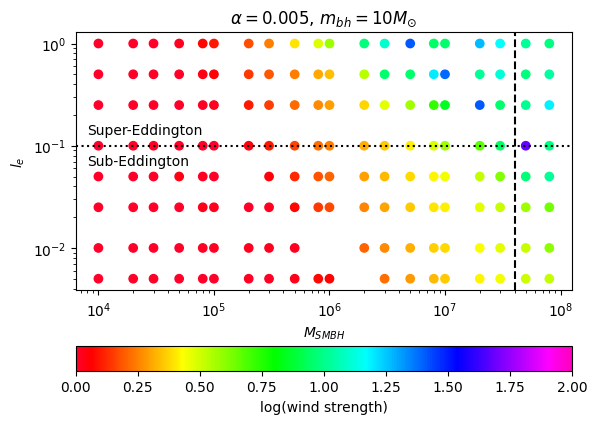

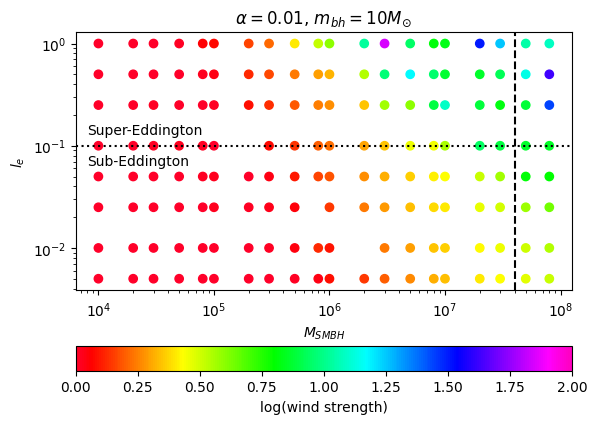

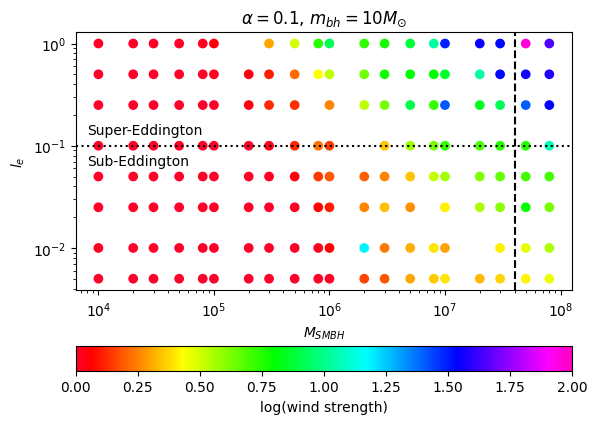

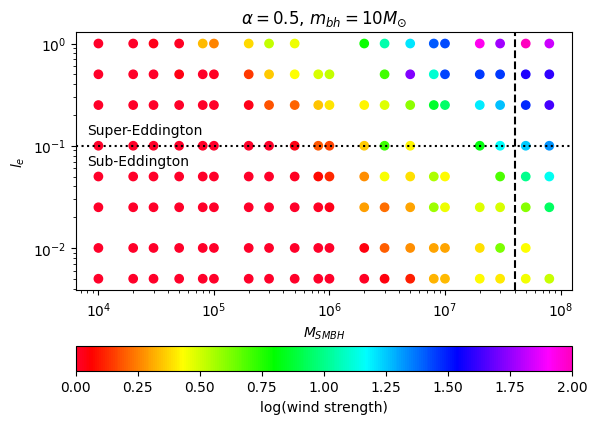

In [274]:
data=file_opener('Torques/SG/Wind/Mig_Torques/Summary_Avg.txt')
groups=data.groupby("alpha", as_index=True)

keys=list(groups.groups.keys())
for key in range(0, len(keys)):
    plt.axvline(4e7, color='black', linestyle='--')
    # plt.annotate('detectable \nundetectable', xy=(3e7, 0.12), rotation=90)

    plt.axhline(0.1, color='black', linestyle='dotted')
    plt.annotate('Super-Eddington', xy=(8e3, 0.13))
    plt.annotate('Sub-Eddington', xy=(8e3, 0.065))
    
    alpha=groups.get_group(keys[key])
    plt.scatter(x=alpha['SMBH/Msun'], y=alpha['le'], c=np.log10(alpha['with_winds_avg']), cmap='gist_rainbow')
    plt.colorbar(label="log(wind strength)", orientation="horizontal")
    plt.clim(0,2)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$M_{SMBH}$')
    plt.ylabel(r'$l_e$')
    plt.title(r'$\alpha=$'f'{keys[key]}, 'r'$m_{bh}=$'f'10'r'$M_{\odot}$')
    plt.savefig(f'Torques/{DT}/Wind/Mig_Torques/Mass_vs_le_alpha_{keys[key]}_avg.pdf')
    plt.show()

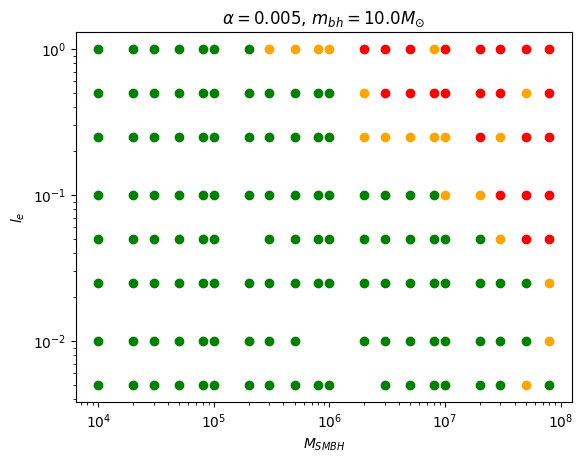

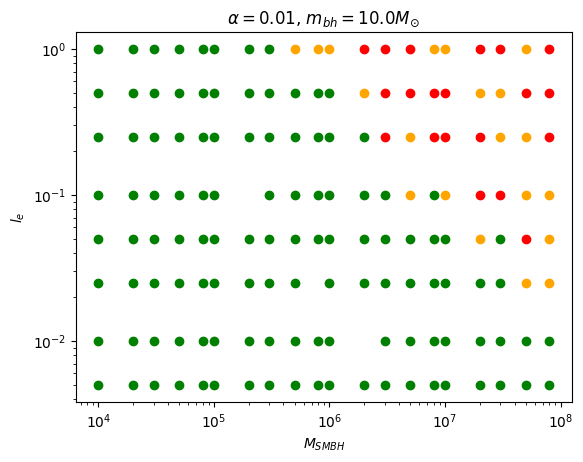

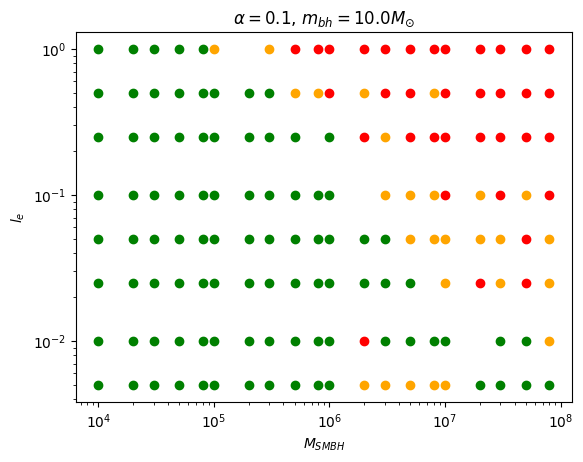

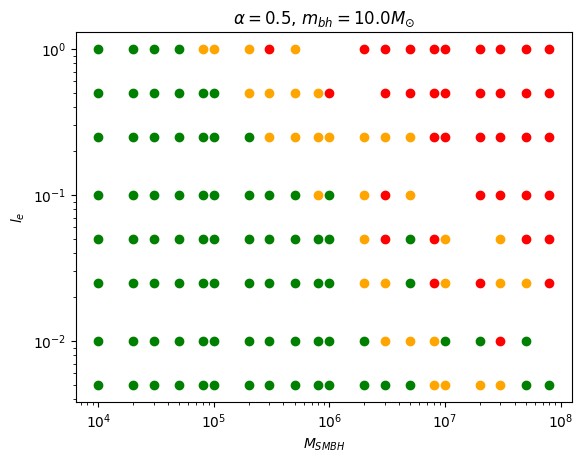

In [169]:
data=file_opener('Torques/SG/Wind/Mig_Torques/Summary_avg.txt')
groups=data.groupby("alpha", as_index=True)

keys=list(groups.groups.keys())
for key in range(0, len(keys)):
    alpha=groups.get_group(keys[key])
    plt.scatter(x= alpha.groupby('winds').get_group('significant')['SMBH/Msun'], y=alpha.groupby('winds').get_group('significant')['le'], color='orange')
    plt.scatter(x= alpha.groupby('winds').get_group('strong')['SMBH/Msun'], y=alpha.groupby('winds').get_group('strong')['le'], color='red')
    plt.scatter(x= alpha.groupby('winds').get_group('weak')['SMBH/Msun'], y=alpha.groupby('winds').get_group('weak')['le'], color='green')
    try:
        plt.scatter(x= alpha.groupby('winds').get_group('insignificant')['SMBH/Msun'], y=alpha.groupby('winds').get_group('insignificant')['le'], color='cyan')
    except KeyError:
        pass

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$M_{SMBH}$')
    plt.ylabel(r'$l_e$')
    plt.title(r'$\alpha=$'f'{keys[key]}, 'r'$m_{bh}=$'f'{Mmean/ct.MSun}'r'$M_{\odot}$')
    plt.savefig(f'Torques/{DT}/Wind/Mig_Torques/Mass_vs_le_alpha_{keys[key]}.pdf')
    plt.show()


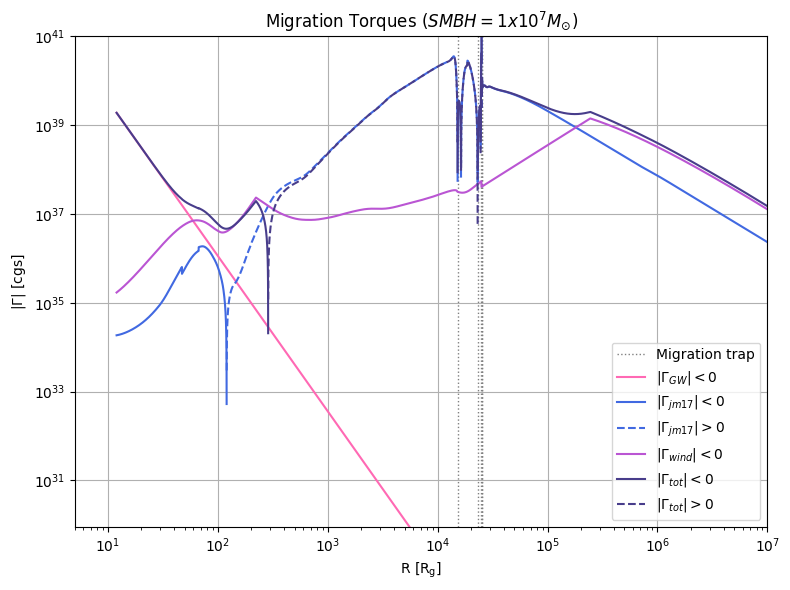

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

for trap in traps:
    ax.axvline(trap *2, color='gray', linestyle=':', linewidth=1, label='Migration trap' if trap == traps[0] else "")

# Mean line: solid for Gamma > 0, dashed for Gamma < 0
# Split into continuous regions of positive or negative torque

sign_changes2 = np.where(np.diff(np.sign(mean_Gamma_GW)) != 0)[0]
split_indices2 = np.concatenate(([0], sign_changes2 + 1, [len(Rs)]))

for i in range(len(split_indices2) - 1):
    start, end = split_indices2[i], split_indices2[i + 1]
    R_seg = Rs[start:end] *2
    G_seg = mean_Gamma_GW[start:end]
    if np.all(G_seg > 0):
        ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{GW}| >0$' if i == 1 else "", color='hotpink')
    elif np.all(G_seg < 0):
        ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{GW}| <0$' if i == 0 else "", color='hotpink')

sign_changes3 = np.where(np.diff(np.sign(mean_Gamma_jm17)) != 0)[0]
split_indices3 = np.concatenate(([0], sign_changes3 + 1, [len(Rs)]))

for i in range(len(split_indices3) - 1):
    start, end = split_indices3[i], split_indices3[i + 1]
    R_seg = Rs[start:end] *2
    G_seg = mean_Gamma_jm17[start:end]
    if np.all(G_seg > 0):
        ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{jm17}| >0$' if i == 1 else "", color='royalblue')
    elif np.all(G_seg < 0):
        ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{jm17}| <0$' if i == 0 else "", color='royalblue')

# sign_changes = np.where(np.diff(np.sign(mean_Gamma_b16)) != 0)[0]
# split_indices = np.concatenate(([0], sign_changes + 1, [len(Rs)]))

# for i in range(len(split_indices) - 1):
#     start, end = split_indices[i], split_indices[i + 1]
#     R_seg = Rs[start:end] *2
#     G_seg = mean_Gamma_b16[start:end]
#     if np.all(G_seg > 0):
#         ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{p10}| >0$' if i == 1 else "", color='darkslateblue')
#     elif np.all(G_seg < 0):
#         ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{p10}| <0$' if i == 0 else "", color='darkslateblue')

if winds==True:
    sign_changes4 = np.where(np.diff(np.sign(mean_Gamma_wind)) != 0)[0]
    split_indices4 = np.concatenate(([0], sign_changes4 + 1, [len(Rs)]))

    for i in range(len(split_indices4) - 1):
        start, end = split_indices4[i], split_indices4[i + 1]
        R_seg = Rs[start:end] *2
        G_seg = mean_Gamma_wind[start:end]
        if np.all(G_seg > 0):
            ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{wind}| >0$' if i == 1 else "", color='mediumorchid')
        elif np.all(G_seg < 0):
            ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{wind}| <0$' if i == 0 else "", color='mediumorchid')


sign_changes = np.where(np.diff(np.sign(mean_Gamma_tot)) != 0)[0]
split_indices = np.concatenate(([0], sign_changes + 1, [len(Rs)]))

for i in range(len(split_indices) - 1):
    start, end = split_indices[i], split_indices[i + 1]
    R_seg = Rs[start:end] *2
    G_seg = mean_Gamma_tot[start:end]
    if np.all(G_seg > 0):
        ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{tot}| >0$' if i == 1 else "", color='darkslateblue')
    elif np.all(G_seg < 0):
        ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{tot}| <0$' if i == 0 else "", color='darkslateblue')



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'R [R$_{\rm g}$]')
ax.set_ylabel(r'$|\Gamma|$ [cgs]')
ax.set_ylim([9e29,1e41])
ax.set_xlim([0.5e1,1e7])
ax.set_title(f'Migration Torques ($SMBH = {MBH_digit}x10^{MBH_power}$'r'${M_{\odot}})$')

plt.legend()
plt.grid()
plt.tight_layout() 
plt.savefig(f'Torques/{DT}/Wind/Migration_Torques_MBH{MBH_digit}e{MBH_power}_alpha{alpha}_damped.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
MBH_power=6
alpha=0.1
mdot=0.1
le=0.01
eps=0.1
spin=0.9

MBH=10**MBH_power * ct.MSun #in kgs

path=f'EMRIs_Jupiter_2/NT_profiles/logMBH{MBH_power}/alpha{alpha}/mdot{mdot}/spin{spin}/'

disk = Novikov.NovikovThorneAGN(Mbh=MBH, alpha=alpha)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk(path=path, save_to_file=False)
print(f'Disk.R: {disk.r}')


disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le= le, eps=eps)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

print(disk.R)

In [ ]:
MBH_powers= 4,5,6,7,8

spins=0.9, 0.99
alphas=0.1, 0.01

mdot = 0.1 #in terms of Ledd
eps = 0.1
le = mdot*eps

steps=int(1e4)

for power in MBH_powers:
    for alpha in alphas:
        for spin in spins:
            print(f'MBH=1e{power} MSun, alpha={alpha}, spin={spin}')
            path=f'EMRIs_Jupiter_2/NT_profiles/logMBH{power}/alpha{alpha}/mdot{mdot}/spin{spin}/'

            MBH=10**power*ct.MSun

            disk = Novikov.NovikovThorneAGN(Mbh=MBH, alpha=alpha, spin=spin)
            Rmin = disk.Rmin
            Rmax = disk.Rmax
            disk.solve_disk(steps=steps, path=path, save_to_file=False)
            print(f'Disk.R: {disk.R}')

In [ ]:
MBH=10**5 * ct.MSun
# spin=0.9
# Rmin=jscript.R_isco_function(MBH, spin)
# R_G=MBH * ct.G /(ct.c*ct.c)
# Rout=1e7*R_G
# sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
# Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

R_G=MBH * ct.G /(ct.c*ct.c)
Rout=1e7*R_G
sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2
diskTQM = pagn.ThompsonAGN(Mbh=MBH, Mdot_out=Mdot_out)

# diskTQM = pagn.ThompsonAGN(Mbh=MBH, Rin=Rmin, Rout=Rout, Mdot_out=Mdot_out)
diskTQM.solve_disk()


In [ ]:
Mdotmaxs=[]
Mdotouts=[]
MBHs=[]

powers=np.linspace(4,8, 1000)

flag=0

for power in powers:
    print(power)
    MBH=10**power * ct.MSun
    MBHs.append(MBH)

    R_G=MBH * ct.G /(ct.c*ct.c)

    Rout=1e7*R_G

    sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)

    Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

    print(Mdot_out)

    diskTQM = edit.ThompsonAGN(Mbh=MBH, Rin=Rmin, Rout=Rout, Mdot_out=Mdot_out)
    diskTQM.solve_disk()
    Mdotmax= diskTQM.Mdotmax * (ct.yr / ct.MSun)
    Mdotout= diskTQM.Mdot_out * (ct.yr / ct.MSun)
    Mdotmaxs.append(Mdotmax)
    Mdotouts.append(Mdotout)
    if Mdotmax>Mdotout and flag==0:
        power_crit=power
        flag+=1

print(f'Mdot max exceeds Mdot out at SMBH = 1e{power_crit} MSun')

plt.plot(powers, Mdotmaxs, color='r', label='$\dot{M}_{max}$')
plt.plot(powers, Mdotouts, color='b', label='$\dot{M}_{out}$')
plt.axvline(x=power_crit)
plt.xlabel('$log(M_{SMBH})$')
plt.ylabel('$\dot{M}~[M_{\odot}yr^{-1}]$')
plt.title("")
plt.legend()
plt.show()
# diskTQM.solve_disk(N=1e4)

In [ ]:
colour='plasma'
cmap = plt.colormaps[colour]

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=100)

i=0
axs[i].plot(disk.R/R_G, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(5, 1e6)
# axs[i].set_ylim(1, 1e7)
axs[i].set_ylim(1e-5, 1e6)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Surface Density vs Radius')

i=1
axs[i].plot(disk.R/R_G, disk.T*jscript.K_to_eV, color=cmap(0.0), label = r"SG")
axs[i].set_ylabel(r'$T [K] $')
axs[i].set_xlabel("r/Rg")

axs[i].set_xscale('log')
axs[i].set_yscale('log')

# axs[i].set_xlim(5, 1e7)
# axs[i].set_ylim(1e1, 3e7)
axs[i].set_ylim(1e-5, 1e6)
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Temperature vs Radius')

i=2

axs[i].plot(disk.R/R_G, disk.h/disk.R, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$h/r$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(1, 1e7)
# axs[i].set_ylim(1, 1e7)
axs[i].set_ylim(1e-5, 1e6)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Disc Thickness vs Radius')
axs[i].legend()

# i=3

# axs[i].plot(disk.R/R_G, disk.rho/1e3, label = r"SG", color=cmap(0.0))
# axs[i].set_ylabel(r'$\rho [?]$')
# axs[i].set_xlabel("r/Rg")

# # axs[i].set_xlim(1, 1e7)
# axs[i].set_ylim(1e-5, 1e5)
# axs[i].set_xscale('log')
# axs[i].set_yscale('log')
# axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

# axs[i].set_title(f'Midplane Surface Density vs Radius')
# axs[i].legend()

i=3

axs[i].plot(disk.R/R_G, disk.tauV, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$\tau_V [?]$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(1, 1e7)
axs[i].set_ylim(1e-5, 1e6)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Tau? vs Radius')
axs[i].legend()


plt.tight_layout()
plt.savefig(f'Pan+Yang/SG_profiles_logMBH{MBH_power}_alpha{alpha}_3.pdf')
plt.show()

In [ ]:
def BHL_accretion(args, obj, MBH, mbh, Mdot, gamma):
    drhodr=jscript.drhodR(obj)
    
    h=obj.h
    cs=obj.cs
    r=obj.R
    rho=obj.rho
    sigma= 2*h*rho

    E=MBH/(2*r)
    J=MBH * np.sqrt(1/(2*E))

    dJdr=jscript.dJdR(obj, J)

    deltav_psi=h*cs*(3-drhodr)/2
    deltav_dr=3/2 * (mbh/(3*MBH))**(1/3) * (1/h) * cs
    deltav_r=np.abs(-Mdot/(2 * np.pi * r * sigma) - gamma/dJdr)
    vrel=((deltav_psi + deltav_dr)**2 + deltav_r**2)**(1/2)
    mdot_BHL= (4 * np.pi * rho * mbh * mbh) / (vrel**2 + cs**2)**(3/2)
    return mdot_BHL

In [ ]:
Mbh=10**4 * ct.MSun
alpha=0.1
mdot=0.1
eps=0.1
mbh=10 * ct.MSun

le=eps*mdot

M=Mbh * ct.G /(ct.c*ct.c)

Ledd=jscript.Ledd(Mbh, X=0.7)
Mdot=le * Ledd / eps

disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

rho=disk.rho
cs=disk.cs
R=disk.R
h=disk.h
sigma=2*h*rho

gamma=jscript.drhodR(disk)

deltav_phi=(3-gamma)/2 * (h / R) * cs
deltav_dr=3/2 * (mbh/(3*Mbh))**(1/3) * (1/h) * cs

vgas=-Mdot/(2 * np.pi * R * sigma)
vstar=-1.3e-6 * (mbh/(10*ct.MSun))/(Mbh/(1e5*ct.MSun)) * (R/10*M)**(-3)
deltav_r=np.abs(vgas-vstar)

vrel_sqr=(deltav_phi + deltav_dr)**2 + deltav_r**2

mdot_BHL=(4 * np.pi * rho * mbh * mbh) / (vrel_sqr + cs**2)**(3/2)

print(mdot_BHL)

In [ ]:
from NT_disk_Eqns_V1 import A_fn, B_fn, C_fn, D_fn, E_fn, Q_fn

In [ ]:
def disc_solver(MBH_power, spin, alpha, mdot, eps, le, steps, path, printing=True, plotting=True, save_to_file=True):
    #general scaling from Abramowicz and Fragile
    MBH=10**MBH_power * ct.MSun #in kgs
    M=MBH * ct.G /(ct.c*ct.c)
    R_G=M

    m=MBH/ct.MSun
    Rsch= 2*ct.G*MBH/ct.c**2

    if mdot==None and le==None:
        raise ValueError('Please provide an accretion rate or Eddington ratio!')
    elif le==None:
        le=mdot*eps
    elif mdot==None:
        mdot=le/eps

    disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

    print(f'SG: {Rmin/R_G} Rg, {disk.Rmin/R_G} Rg, {disk.R[0]/R_G} Rg')

    Rout=Rmax
    sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
    Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

    diskTQM = pagn.ThompsonAGN(Mbh=MBH, Rout=Rout, Rin=Rmin, Mdot_out=Mdot_out)
    diskTQM.solve_disk()

    print(f'TQM: {Rmin/R_G} Rg, {diskTQM.Rin/R_G} Rg, {diskTQM.R[0]/R_G} Rg')

    Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc
    r_isco=jscript.R_isco_function(MBH, spin)

    R=np.logspace(np.log10(r_isco), np.log10(Rmax), steps+1)
    # R=np.linspace(r_isco, Rmax, steps+1)

    R_im=jscript.R_inner_mid(r_isco, MBH, mdot, alpha)
    R_mo=jscript.R_mid_outer(r_isco, mdot)
    R_oa=jscript.R_outer_AGN(r_isco, MBH, mdot, alpha)

    R_agn=disk.R_AGN/R_G

    As=[]
    Bs=[]
    Cs=[]
    Ds=[]
    Es=[]
    Qs=[]

    coefficient=[]

    Rs=[]

    k=50
    if printing==True:
        print(R_oa/R_agn)
        print(f'Initial Radius = {R[k]/R_G} Rg, R_isco = {r_isco/R_G} Rg')

    for i in range(k, steps+1):
        r=R[i]
        y=np.sqrt(r/M)
        rstar=(r/M)
        r_im=jscript.r_in_mid(y, MBH, spin, mdot, alpha)
        r_mo=jscript.r_mid_outer(y, MBH, spin, mdot)

        A=A_fn(y, spin)
        B=B_fn(y, spin)
        C=C_fn(y, spin)
        D=D_fn(y, spin)
        E=E_fn(y, spin)
        Q=Q_fn(y, MBH, spin)

        coefficient.append(A**(2/3) * D**(-1/3) * Q**(2/3))

        As.append(A)
        Bs.append(B)
        Cs.append(C)
        Ds.append(D)
        Es.append(E)
        Qs.append(Q)

        Rs.append(rstar)
        
    plt.plot(Rs, As, label='A')
    # plt.plot(Rs, Bs, label='B')
    # plt.plot(Rs, Cs, label='C')
    plt.plot(Rs, Ds, label='D')
    # plt.plot(Rs, Es, label='E')
    plt.plot(Rs, Qs, label="Q")

    plt.plot(Rs, coefficient, label='coeff')

    plt.xlabel('R/M')

    plt.xscale('log')
    plt.yscale('log')

    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
mdot = 0.1 #in terms of Ledd
eps = 0.1
le = mdot*eps
# mdot=le/eps

disc_solver(4, 0.9, 0.1, mdot, eps, le, steps, path, printing=True, plotting=True, save_to_file=True)